RFP: Scientific plots
=================

This notebooks collects all the source code for the scientific figures presented in the lecture notes or during lectures. Occasionally some other figures are also included, which might be of interest for students.

The notebook is a bit messy in the sense, that some functions are repeated in it, but the goal was that figures should be possible to be created without depending on other code cells. Due to the same reason we have not copied some helper functions into a separate module.

Some code cells require openMC to be installed. 

authors: Zsolt Elter, Erik Branger, Markus Preston

# Table of contents
1. [Basics of nuclear physics](#basicnuclearphysics)
    1. [Binding curve](#binding)
    2. [Radioactive decay chains](#decay)
    3. [Decay series](#decayseries)
    4. [Playing with energy levels](#levels)
    5. [Cross sections](#xs)
    6. [Scattering](#scattering)
    7. [Doppler-effect](#doppler)
    8. [Fission](#fission)
2. [Fission chain reactions and neutron spectrum](#fissionchainspectrum)
    1. [Critical fission trees](#trees)
    2. [Simple kinetics](#simplekinetics)
    3. [Slowing down and spectrum](#spectrum)
    4. [Neutron cycle](#neutroncycle)
3. [Neutron transport and diffusion](#transport)
    1. [Transport vs diffusion at boundaries](#transportvsdiffusion)
    2. [Analytic solutions of diffusion](#analyticdiffusion)
    3. [Reflected geometries](#reflected)
    4. [Control rod effects](#controlrod)
4. [Time dependence](#time)
    1. [Point kinetics](#kinetics)
    2. [Subcritical systems](#subcritical)
    3. [Depletion](#depletion)
5. [Appendix](#appendix)


# Basics of nuclear physics <a name="basicnuclearphysics"></a>

## Binding curve <a name="binding"></a>

Mass data of nuclides comes from https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl?ele=&ascii=html


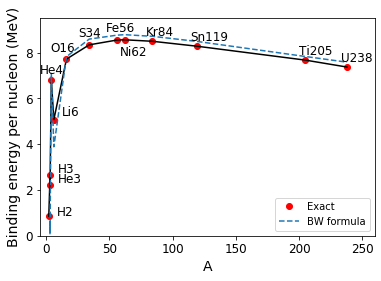

In [1]:
import matplotlib.pyplot as plt

mn=1.00866491588
mp=1.007276466621 #note that mp<mn, so p->n+e+ cannot happen naturally

nucBEN={'H2': {'Z': 1, 'A': 2, 'm': 2.01410177812},
        'H3': {'Z': 1, 'A': 3, 'm': 3.0160492779},
        'He3': {'Z': 2, 'A': 3, 'm': 3.0160293201},
        'He4': {'Z': 2, 'A': 4, 'm': 4.002603254},
        'Li6': {'Z': 3, 'A': 6, 'm': 6.0151228874},
      #  'Li7': {'Z': 3, 'A': 7, 'm': 7.0160034366},
        #'C12': {'Z': 6, 'A': 12, 'm': 12.0000000},
       # 'N14': {'Z': 7, 'A': 14, 'm': 14.00307400443},
        'O16': {'Z': 8, 'A': 16, 'm': 15.99491461957},
        'S34': {'Z': 16, 'A': 34, 'm': 33.96786701},
        'Fe56': {'Z': 26, 'A': 56, 'm': 55.9349375},
        'Ni62': {'Z': 28, 'A': 62, 'm': 61.92834537},
        'Kr84': {'Z': 36, 'A': 84, 'm': 83.9114977282},
        'Sn119': {'Z': 50, 'A': 119, 'm': 118.90331117},
        'Ti205': {'Z': 81, 'A': 205, 'm': 204.9744278},
        #'U235': {'Z': 92, 'A': 235, 'm': 235.0439301},
        'U238': {'Z': 92, 'A': 238, 'm': 238.0507884}}

def Epsilon(masses):
    """
    calculates average binding energy per nucleon
    """
    muc2=931.49410242 #MeV
    dW=(masses['Z']*mp+(masses['A']-masses['Z'])*mn-masses['m'])*muc2
    return dW/masses['A']

def EpsilonBW(A,Z):
    N=A-Z
    if Z%2==0 and N%2==0:
        D=1
    elif Z%2!=0 and N%2!=0:
        D=-1
    else:
        D=0
    #epsilon=16*A-18*A**(2/3)-24*(A-2*Z)/A-0.7*Z**2/A**(1/3)+D*33/A**(3/4)
    epsilon=15.75*A-17.8*A**(2/3)-94.8*(A/2-Z)**2/A-0.71*Z**2/A**(1/3)+D*34/A**(3/4)
    return epsilon/A

As=[]
Eps=[]
Mass=[]
EpsBW=[]
labels=[]
for iso in nucBEN:
    As.append(nucBEN[iso]['A'])
    Eps.append(Epsilon(nucBEN[iso]))
    EpsBW.append(EpsilonBW(nucBEN[iso]['A'],nucBEN[iso]['Z']))
    labels.append(iso)

import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.figure()
plt.plot(As,Eps,'ro',label='Exact')
plt.plot(As,Eps,'k-')
plt.plot(As,EpsBW,'--',label='BW formula')
for A,E,l in zip(As,Eps,labels):
    if l=='Ni62':
        plt.annotate(l,(A-4,E*0.92),fontsize=12)
    elif l=='O16':
        plt.annotate(l,(A-13,E*1.04),fontsize=12)
    elif l in ['H2','H3','He3','Li6']:
        plt.annotate(l,(A+6.5,E*1.03),fontsize=12)
    elif l in ['He4','S34','Fe56']:
        plt.annotate(l,(A-9,E*1.04),fontsize=12)
    else:
        plt.annotate(l,(A-5,E*1.03),fontsize=12)
plt.xlabel('A',fontsize=14)
plt.ylim(0,9.5)
plt.xlim(-5,260)
plt.ylabel('Binding energy per nucleon (MeV)',fontsize=14)
plt.legend()
#plt.savefig('01-bindingcurve.png',dpi=150)
plt.show()

## Radioactive decay chain <a name="decay"></a>

We assume a simple decaychain, when a parent decays into a daughter, which decays, but we do not keep track of the grandchild: $P \rightarrow D \rightarrow$. In this case the analytic solutions are

$$ N_{P} (t) = N_P(0)e^{-\lambda_{P}t}$$

$$ N_{D} (t) = \frac{\lambda_P}{\lambda_P - \lambda_{D}}N_P(0)(e^{-\lambda_{D}t} - e^{-\lambda_{P}t}) $$


We solve this problem in 4 ways:

- Monte Carlo: decay times are completely random
- Analytic: plotting the above functions
- SciPy numeric
- Running the radioactivedecay package

### nuclide concentration

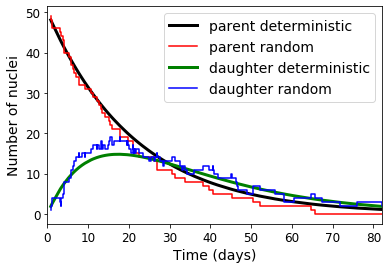

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
label_size = 12
%matplotlib inline
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

TP=14.9 #d, parent
lP=np.log(2)/TP
TD=9.9
lD=np.log(2)/TD

N0=50

decayParent=np.sort(np.random.exponential(1/lP,N0))
decayDaughter=np.sort(decayParent+np.random.exponential(1/lD,N0))

decayTimes = np.sort(np.concatenate((decayParent, decayDaughter)))
NP_random=np.linspace(N0-1,0,N0)
ND_random=np.cumsum(np.array([1 if t in decayParent else -1 for t in decayTimes]))

#how many daughter we have: the number of parent which already decayed minus the daughter which already decayed
#TODO this is wrong! due to the sorting it has to be wrong, it might happen that something decays before it is actuall
# being created 
# but maybe it is not wrong, it seems to fit well for large N0 to the theory
#NAc_random=np.array([(N0-NRa_random[i])-len(decayDaughter[decayDaughter<=dt]) for i,dt in enumerate(decayParent)])

def NDaughter(t,lp,ld):
    """Number of daughter nuclei
    
    Parameters
    ----------
    t : float or array-like
        time in days
    """
    N=(lp/(lp-ld))*(np.exp(-ld*t)-np.exp(-lp*t))
    return N

def NParent(t,lp):
    """Number of parent nuclei
    
    Parameters
    ----------
    t : float or array-like
        time in days
    """
    N=np.exp(-lp*t)
    return N


plt.figure()
plt.plot(decayTimes,N0*NParent(decayTimes,lP),'k',lw=3,label='parent deterministic')
plt.step(decayParent,NP_random,'r',label='parent random')
plt.plot(decayTimes,N0*NDaughter(decayTimes,lP,lD),'g',lw=3,label='daughter deterministic')
plt.step(decayTimes,ND_random,'b',label='daughter random')
plt.xlim(0,decayParent[-1])
plt.xlabel('Time (days)',fontsize=14)
plt.ylabel('Number of nuclei',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('1-radioactivdecay_daughterparent_LongDaughter.png',dpi=300)
plt.show()

### activity

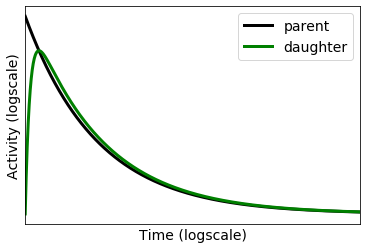

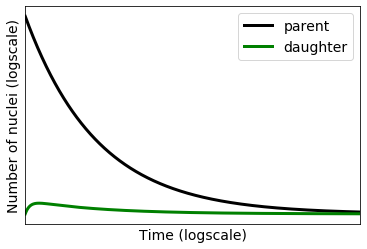

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

TP=14.9 #d, parent
lP=np.log(2)/TP
TD=9.8/10
lD=np.log(2)/TD


def NDaughter(t,lp,ld):
    """Number of daughter nuclei
    
    Parameters
    ----------
    t : float or array-like
        time in days
    """
    N=(lp/(lp-ld))*(np.exp(-ld*t)-np.exp(-lp*t))
    return N

def NParent(t,lp):
    """Number of parent nuclei
    
    Parameters
    ----------
    t : float or array-like
        time in days
    """
    N=np.exp(-lp*t)
    return N

decayTimes=np.linspace(0,100,1001)
N0=50000
plt.figure()
plt.plot(decayTimes,lP*N0*NParent(decayTimes,lP),'k',lw=3,label='parent')
plt.plot(decayTimes,lD*N0*NDaughter(decayTimes,lP,lD),'g',lw=3,label='daughter')
plt.xlim(0,100)
plt.xlabel('Time (logscale)',fontsize=14)
plt.ylabel('Activity (logscale)',fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
#plt.savefig('1-radioactivdecay_daughterparent_secularActivity.png',dpi=300)
plt.show()

plt.figure()
plt.plot(decayTimes,N0*NParent(decayTimes,lP),'k',lw=3,label='parent')
plt.plot(decayTimes,N0*NDaughter(decayTimes,lP,lD),'g',lw=3,label='daughter')
plt.xlim(0,100)
plt.xlabel('Time (logscale)',fontsize=14)
plt.ylabel('Number of nuclei (logscale)',fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
#plt.savefig('1-radioactivdecay_daughterparent_secularNuclei.png',dpi=300)
plt.show()

### secular

/home/zsolt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/zsolt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


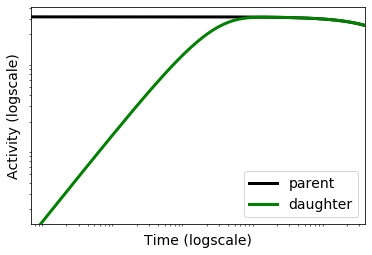

/home/zsolt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/zsolt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


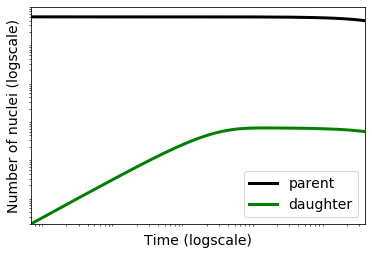

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
label_size = 12
%matplotlib inline
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

TP=30*365 #d, parent
lP=np.log(2)/TP
TD=13.8888889
lD=np.log(2)/TD


def NDaughter(t,lp,ld):
    """Number of daughter nuclei
    
    Parameters
    ----------
    t : float or array-like
        time in days
    """
    N=(lp/(lp-ld))*(np.exp(-ld*t)-np.exp(-lp*t))
    return N

def NParent(t,lp):
    """Number of parent nuclei
    
    Parameters
    ----------
    t : float or array-like
        time in days
    """
    N=np.exp(-lp*t)
    return N

decayTimes=np.linspace(0,30*365,100001)
N0=50000
plt.figure()
plt.loglog(decayTimes,lP*N0*NParent(decayTimes,lP),'k',lw=3,label='parent')
plt.loglog(decayTimes,lD*N0*NDaughter(decayTimes,lP,lD),'g',lw=3,label='daughter')
plt.xlim(0,10*365)
plt.xlabel('Time (logscale)',fontsize=14)
plt.ylabel('Activity (logscale)',fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
#plt.savefig('1-radioactivdecay_daughterparent_secularActivity.png',dpi=300)
plt.show()

plt.figure()
plt.loglog(decayTimes,N0*NParent(decayTimes,lP),'k',lw=3,label='parent')
plt.loglog(decayTimes,N0*NDaughter(decayTimes,lP,lD),'g',lw=3,label='daughter')
plt.xlim(0,10*365)
plt.xlabel('Time (logscale)',fontsize=14)
plt.ylabel('Number of nuclei (logscale)',fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
#plt.savefig('1-radioactivdecay_daughterparent_secularNuclei.png',dpi=300)
plt.show()

### with radioactivedecay package

this needs previous intallation of the package

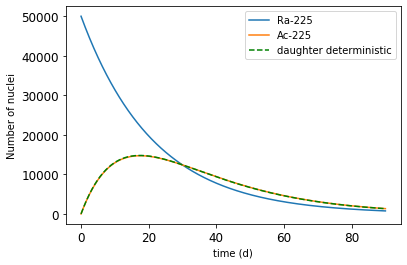

In [5]:
import radioactivedecay as rd
TP=14.9 #d, parent
lP=np.log(2)/TP

TD=9.9
lD=np.log(2)/TD
N0=5e4
activities={'Ra-225': N0*lP}

act_evo={}
time=np.linspace(0,90,1001)
for t in time:
    inv_t0 = rd.Inventory(activities)
    inv_t1 = inv_t0.decay(t, 'd')
    for key in inv_t1.contents:
        if key in act_evo:
            act_evo[key].append(inv_t1.contents[key])
        else:
            act_evo[key]=[inv_t1.contents[key]]

lam={'Ra-225':lP,'Ac-225':lD}
plt.figure()
for key in ['Ra-225','Ac-225']:
    plt.plot(time,act_evo[key]/lam[key],label=key)
plt.plot(time,N0*NDaughter(time,lP,lD),'g--',label='daughter deterministic')
plt.xlabel('time (d)')
plt.legend()
plt.ylabel('Number of nuclei')
plt.show()

### with scipy

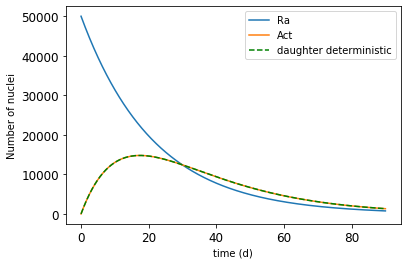

In [6]:
def derivDaughter(t,y,lp,ld):
    return np.array([-lp*y[0],lp*y[0]-ld*y[1]])

from scipy.integrate import solve_ivp

sol=solve_ivp(derivDaughter,(0,240*60*60),[N0,0],t_eval=np.linspace(0,90,1001),args=(lP, lD))

plt.figure()
plt.plot(sol.t,sol.y[0],label='Ra')
plt.plot(sol.t,sol.y[1],label='Act')
plt.plot(np.linspace(0,90,1001),N0*NDaughter(np.linspace(0,90,1001),lP,lD),'g--',label='daughter deterministic')
plt.xlabel('time (d)')
plt.legend()
plt.ylabel('Number of nuclei')
plt.show()

## Decay series <a name="decayseries"></a>

### U-235 series with radioactivedecay package 

First, we are going to use the radioactivedecay package to investigate the decay series of U-235. And one of the main reasons to do so is because this might not be the ideal choice, so it highlights, that sometimes one either needs to optimize the package which is intended to be used, or needs to live with the fact, that some things will not be ideal. So in which sense is radiactivedecay not ideal for us:

- It only contains radioisotopes, so the stable end product will not be included.
- It names nuclides as 'U-235', so we need to map the chemical symbol to the proton number in some other way.

Let us define a pure U-235 source, and see what radioactive isotopes are created after 1 year. 

In [7]:
import radioactivedecay as rd
activities={'U-235': 1}
inv_t0 = rd.Inventory(activities)
inv_t1 = inv_t0.decay(1, 'y')

In [8]:
inv_t1.contents

{'Ac-227': 3.3048365358109017e-07,
 'At-219': 2.7360607685703056e-13,
 'Bi-211': 2.5956444040276934e-07,
 'Bi-215': 2.653868405770999e-13,
 'Fr-223': 4.5601246068386735e-09,
 'Pa-231': 2.106924903890382e-05,
 'Pb-211': 2.5956786281782615e-07,
 'Po-211': 7.163978163899106e-10,
 'Po-215': 2.5962559512159556e-07,
 'Ra-223': 2.596254355853422e-07,
 'Rn-219': 2.5962532988055327e-07,
 'Th-227': 2.8139030996946633e-07,
 'Th-231': 0.9999999990195513,
 'Tl-207': 2.588404353094085e-07,
 'U-235': 0.9999999990154159}

The drawback of this package is, that the proton number is not stored. We could write a function or use an other package to overcome this issue, however for the moment, we rather just tabulate the proton number of the elements of interest.

In [9]:
symToZ={'U': 92,
        'Tl':81,
        'Th':90,
       'Rn':86,
       'Ra':88,
       'Po':84,
       'Pb':82,
       'Pa':91,
       'Fr':87,
       'Bi':83,
       'At':85,
       'Ac':89}


In [10]:
inv_t1.decay_modes()

{'Ac-227': ['β-', 'α'],
 'At-219': ['α'],
 'Bi-211': ['α', 'β-'],
 'Bi-215': ['β-'],
 'Fr-223': ['β-', 'α'],
 'Pa-231': ['α'],
 'Pb-211': ['β-'],
 'Po-211': ['α'],
 'Po-215': ['α'],
 'Ra-223': ['α'],
 'Rn-219': ['α'],
 'Th-227': ['α'],
 'Th-231': ['β-'],
 'Tl-207': ['β-'],
 'U-235': ['α']}

In [11]:
inv_t1.half_lives()

{'Ac-227': 687057394.61376,
 'At-219': 56.0,
 'Bi-211': 128.4,
 'Bi-215': 456.0,
 'Fr-223': 1320.0,
 'Pa-231': 1033804898380.8,
 'Pb-211': 2166.0,
 'Po-211': 0.516,
 'Po-215': 0.001781,
 'Ra-223': 987552.0,
 'Rn-219': 3.96,
 'Th-227': 1613952.0,
 'Th-231': 91872.0,
 'Tl-207': 286.2,
 'U-235': 2.221607596032e+16}

In [12]:
#let's create a color map

import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=min(np.log10(list(inv_t1.half_lives().values()))), 
                                   vmax=max(np.log10(list(inv_t1.half_lives().values()))))

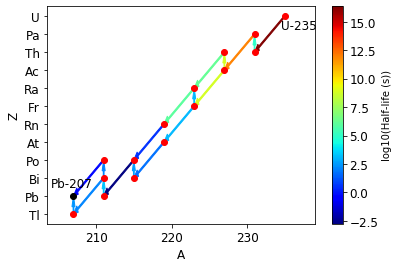

In [13]:
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
#TODO At-219 is missing a beta decay apparently!
def createDotArrow(nuc):
    sym,A=iso.split('-')
    Z=symToZ[sym] #if it doesn't find symToZ within the function, looks outside. Be careful with such.
    A=int(A)
    plt.plot(A,Z,'ro')
    for dm in nuc.decay_modes():
        if dm=='α':
            plt.arrow(A,Z,-4,-2,width=0.1,length_includes_head=True,head_width=0.4,color=cmap(norm(np.log10(nuc.half_life()))))
        if dm=='β-':
            plt.arrow(A,Z,0,1,width=0.1,length_includes_head=True,head_width=0.4,color=cmap(norm(np.log10(nuc.half_life()))))

#plt.figure(figsize=(8,5))
for iso in inv_t1.contents:
    nuc=rd.Radionuclide(iso)
    if nuc.radionuclide=='At-219':
        nuc.decay_modes().append('β-')
    createDotArrow(nuc)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),label='log10(Half-life (s))')
plt.plot(207,82,'ko')
plt.yticks(list(symToZ.values()),list(symToZ.keys()))
plt.annotate('Pb-207',(204.0,82.5),fontsize=12)
plt.annotate('U-235',(234.5,91.3),fontsize=12)
plt.xlabel('A',fontsize=12)
plt.ylabel('Z',fontsize=12)
plt.xlim(203.5,239)
#plt.savefig('1-u235_decayseries.png',dpi=300)
plt.show()

### Decay series with xml

Here instead we will use a depletion chain pre-computed for openmc (accessed from https://openmc.org/depletion-chains/). This will give as somewhat better flexibility, and a messier code. We can modify the starting nuclide. The plotting bit is fairly similar as before.

First, let's have a dictionary for all the elements, then read the xml file.

In [14]:
symToZ= {'Mt': 109, 'Hs': 108, 'Bh': 107, 'Sg': 106, 'Db': 105, 'Rf': 104, 'Lr': 103, 'No': 102, 'Md': 101, 'Fm': 100, 'Es': 99, 'Cf': 98, 'Bk': 97, 'Cm': 96, 'Am': 95, 'Pu': 94, 'Np': 93, 'U': 92, 'Pa': 91, 'Th': 90, 'Ac': 89, 'Ra': 88, 'Fr': 87, 'Rn': 86, 'At': 85, 'Po': 84, 'Bi': 83, 'Pb': 82, 'Tl': 81, 'Hg': 80, 'Au': 79, 'Pt': 78, 'Ir': 77, 'Os': 76, 'Re': 75, 'W': 74, 'Ta': 73, 'Hf': 72, 'Lu': 71, 'Yb': 70, 'Tm': 69, 'Er': 68, 'Ho': 67, 'Dy': 66, 'Tb': 65, 'Gd': 64, 'Eu': 63, 'Sm': 62, 'Pm': 61, 'Nd': 60, 'Pr': 59, 'Ce': 58, 'La': 57, 'Ba': 56, 'Cs': 55, 'Xe': 54, 'I': 53, 'Te': 52, 'Sb': 51, 'Sn': 50, 'In': 49, 'Cd': 48, 'Ag': 47, 'Pd': 46, 'Rh': 45, 'Ru': 44, 'Tc': 43, 'Mo': 42, 'Nb': 41, 'Zr': 40, 'Y': 39, 'Sr': 38, 'Rb': 37, 'Kr': 36, 'Br': 35, 'Se': 34, 'As': 33, 'Ge': 32, 'Ga': 31, 'Zn': 30, 'Cu': 29, 'Ni': 28, 'Co': 27, 'Fe': 26, 'Mn': 25, 'Cr': 24, 'V': 23, 'Ti': 22, 'Sc': 21, 'Ca': 20, 'K': 19, 'Ar': 18, 'Cl': 17, 'S': 16, 'P': 15, 'Si': 14, 'Al': 13, 'Mg': 12, 'Na': 11, 'Ne': 10, 'F': 9, 'O': 8, 'N': 7, 'C': 6, 'B': 5, 'Be': 4, 'Li': 3, 'He': 2, 'H': 1}

In [15]:
import xml.etree.ElementTree as ET
tree = ET.parse('chain_endfb71_pwr.xml')
root = tree.getroot()

In [16]:
nuclides={}
for child in root:
    nuclides[child.attrib['name']]=child.attrib
    if 'decay_modes' in child.attrib:
        nuclides[child.attrib['name']]['decay']=[grandchild.attrib for grandchild in child if grandchild.tag=='decay']

In [17]:
decay_modes={}
half_lifes={}
import re
def addNuclide(nucl):
    if 'half_life' in nuclides[nucl]:
        half_lifes[nucl]=float(nuclides[nucl]['half_life'])
        #I will only consider alpha and beta- decay. It could be extended to others, also notice eg. Tl210 has 'beta-,n'
        decay_modes[nucl]=[dec['type'] for dec in nuclides[nucl]['decay'] if ('alpha'==dec['type'] or 'beta-'==dec['type'])]
        targets=[dec['target'] for dec in nuclides[nucl]['decay'] if ('alpha'==dec['type'] or 'beta-'==dec['type'])]
        for target in targets:
            addNuclide(target)
    else:
        decay_modes[nucl]=['stable']
startNuc='U238'
startA=int(re.split(r'(\d+)', startNuc.split('_')[0])[1])
addNuclide(startNuc)

In [18]:
half_lifes

{'U238': 1.40999e+17,
 'Th234': 2082240.0,
 'Pa234_m1': 69.54,
 'U234': 7747390000000.0,
 'Th230': 2378810000000.0,
 'Ra226': 50492200000.0,
 'Rn222': 330350.4,
 'Po218': 185.88,
 'Pb214': 1608.0,
 'Bi214': 1194.0,
 'Tl210': 78.0,
 'Pb210': 700578700.0,
 'Hg206': 499.2,
 'Tl206': 252.12,
 'Bi210': 433036.8,
 'Po210': 11955690.0,
 'Po214': 0.0001643,
 'At218': 1.5,
 'Rn218': 0.035}

In [19]:
decay_modes

{'U238': ['alpha'],
 'Th234': ['beta-'],
 'Pa234_m1': ['beta-'],
 'U234': ['alpha'],
 'Th230': ['alpha'],
 'Ra226': ['alpha'],
 'Rn222': ['alpha'],
 'Po218': ['alpha', 'beta-'],
 'Pb214': ['beta-'],
 'Bi214': ['alpha', 'beta-'],
 'Tl210': ['beta-'],
 'Pb210': ['alpha', 'beta-'],
 'Hg206': ['beta-'],
 'Tl206': ['beta-'],
 'Pb206': ['stable'],
 'Bi210': ['alpha', 'beta-'],
 'Po210': ['alpha'],
 'Po214': ['alpha'],
 'At218': ['alpha', 'beta-'],
 'Rn218': ['alpha']}

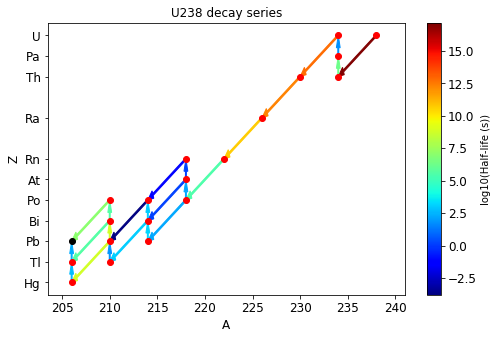

In [20]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=min(np.log10(list(half_lifes.values()))), 
                                   vmax=max(np.log10(list(half_lifes.values()))))

label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

def createDotArrow(nuc):
    import re
    sym,A,_=re.split(r'(\d+)', nuc.split('_')[0]) #will fail if an isomer is present
    Z=symToZ[sym] #if it doesn't find symToZ within the function, looks outside. Be careful with such.
    A=int(A)
    if 'stable' in decay_modes[nuc]:
        plt.plot(A,Z,'ko')
    else:
        plt.plot(A,Z,'ro')
    for dm in decay_modes[nuc]:
        if dm=='alpha':
            plt.arrow(A,Z,-4,-2,width=0.1,length_includes_head=True,head_width=0.4,color=cmap(norm(np.log10(half_lifes[nuc]))))
        if dm=='beta-':
            plt.arrow(A,Z,0,1,width=0.1,length_includes_head=True,head_width=0.4,color=cmap(norm(np.log10(half_lifes[nuc]))))

plt.figure(figsize=(8,5))
for nuc in decay_modes:
    createDotArrow(nuc)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),label='log10(Half-life (s))')
#plt.yticks(list(symToZ.values()),list(symToZ.keys()))
#we take only the Element symbols which are present to define the yticks
currentSymToZ={re.split(r'(\d+)', key.split('_')[0])[0]: symToZ[re.split(r'(\d+)', key.split('_')[0])[0]] for key in decay_modes}
plt.yticks(list(currentSymToZ.values()),list(currentSymToZ.keys()))
#plt.annotate('Pb-207',(204.0,82.5),fontsize=12)
#plt.annotate('U-235',(234.5,91.3),fontsize=12)
plt.xlabel('A',fontsize=12)
plt.ylabel('Z',fontsize=12)
plt.xlim(203.5,startA+3)
plt.title('%s decay series'%startNuc)
#plt.savefig('1-%s_decayseries.png'%startNuc,dpi=300)
plt.show()

## Playing with energy levels <a name="levels"></a>

In the following we are creating the plots related to energy levels.

The first function is a reader for cross sections downloaded from the KAERI cite. Note that this function excepts an string containing html code. One could modify it to directly accept a url, however we decided agains this. 

In [21]:
def getXS(content):
    """Function to extract data from the html content provided by KAERI.
    the content has a shape as follows like:    
    Energy(eV) XS(b)<br>
    1.00000E-05 3.07139<br>"""
    energy=[]
    xs=[]
    flag=False
    i=0
    for line in content:
        x=line.strip().split()
        if  x[0]==b'Energy(eV)':
            flag=True
            continue
        if x[0]==b'</span>':
            flag=False
        if flag:
            energy.append(float(x[0]))
            xs.append(float(x[1][:-4]))
    return np.array(energy), np.array(xs)

import urllib.request

import numpy as np
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Na-23 resonances vs Na-24 levels

The levels of the Na-24 can be accessed from IAEA NDS. Here for simplicity we only include couple of levels in keV: 

`levels=[6905,6962.21,6966.78 ,6993.37,7010.29,7068.5,7072,7058,7096.6,7141.6,7151.3]`

then we transform between LAB and CM system:

$$E_{CM}=\frac{M}{m+M}E_{LAB}$$

we shift all the compound levels with the difference of the ground state energies, and conver between LAB and CM. On the plot we can see how the compound levels match the resonances.

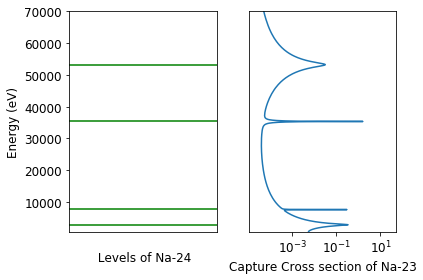

In [22]:
website23='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,11,23,1125,3,102'
with urllib.request.urlopen(website23) as response:
    content23 = response.readlines()
    
energy,xs=getXS(content23)

    
u=931.49410242
gs23n=22.98976928196*u+939.5654133 #ground state of Na23 and neutron 
gs24=23.99096295*u                 #ground state of Na24
ltoc=22.98976928196/(22.98976928196+939.5654133/u) #M/(m+M)=ltoc to get Ec=ltoc*El
shift=(gs23n-gs24)*1000

levels=[6905,6962.21,6966.78 ,6993.37,7010.29,7068.5,7072,7058,7096.6,7141.6,7151.3]

import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig, axs = plt.subplots(1, 2)
fig.subplots_adjust(hspace=.7)
fig.subplots_adjust(wspace=.3)
axs[1].semilogx(xs,energy)
for l in levels:
    axs[0].axhline((l-shift)*1e3/ltoc,color='g') #convert LAB energy from CoM energy
axs[0].set_ylim([500,7e4])
axs[0].set_xticks([])
axs[1].set_yticks([])
axs[0].set_ylabel('Energy (eV)',fontsize=12)
axs[0].set_xlabel('\n Levels of Na-24',fontsize=12)
axs[1].set_xlabel('Capture Cross section of Na-23',fontsize=12)
axs[1].set_ylim([500,7e4])
plt.tight_layout()
#plt.savefig('01-na23xs-levels.png',dpi=300)
plt.show()


### why did we need to conver between CM and LAB?

Just to justify visually as well, we can show, what would happen if we do not convert between CM and LAB energies.

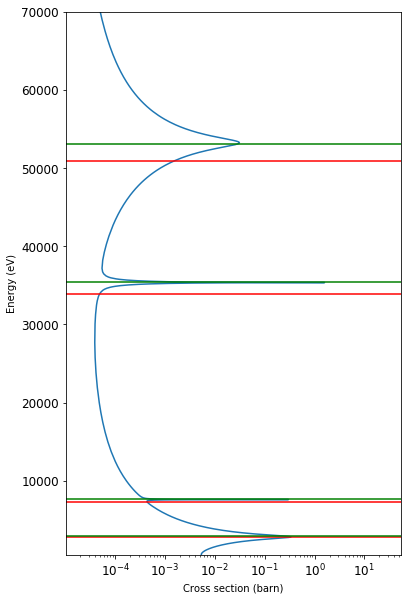

In [23]:
energy,xs=getXS(content23)

plt.figure(figsize=(6,10))
plt.semilogx(xs,energy)
plt.ylabel('Energy (eV)')
plt.xlabel('Cross section (barn)')
for l in levels:
    plt.axhline((l-shift)*1e3,color='r')
    plt.axhline((l-shift)*1e3/ltoc,color='g')
plt.ylim(500,7e4)

plt.show()

### How many levels of Na-24 are above the ground state of Na-23?

Here we tabulated a bit more levels of Na-24 (again, assessed from IAEA NDS).

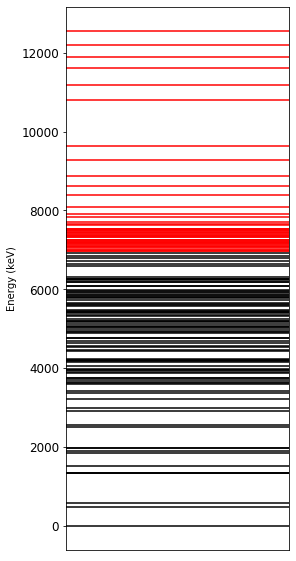

In [24]:
levels=[0,472.2074,563.1988,1341.458,1344.633,1346.621,1512.4,1846.012,1885.493,1960.87,1977.07,2513.358,2562.37,2904.008,2977.783,3216.7,3371.74,3413.199,3589.326,3628.36,3655.91,3681.83,3737.62,3745.062,3865.62,3896,3936.3,3943.46,3977.326,4048.46,4143.1,4186.8,4196.41,4207.099,4220,4441.643,4459,4526,4561.987,4621.58,4690.39,4750.987,4772,4891.27,4908.28,4939.52,4980,5031.05,5045.028,5059.631,5117.28,5160,5180.55,5192.35,5252.26,5308.1,5339.02,5397.009,5408.29,5432,5454.61,5479.05,5571.57,5585,5628.4,5660,5720,5774,5789.4,5809.479,5850.65,5862.97,5896.69,5918.222,5953.31,5967.37,6072.721,6088.2,6176.1,6183.1,6222.33,6247.513,6251.27,6257,6305.9,6578,6640,6715,6787,6846,6905,6962.21,6966.78,6993.37,7010.29,7068.5,7072,7085.8,7096.6,7141.6,7151.3,7163.1,7186.2,7187,7192.3,7245.6,7246.1,7251.8,7324.4,7327.6,7336.7,7372.7,7386.3,7425.5,7433.7,7446.1,7473.9,7499.8,7511.3,7519,7532.3,7533,7627.4,7655.5,7708,7832,7903,8080,8390,8610,8860,9280,9630,10790,11190,11610,11900,12190,12540]
plt.figure(figsize=(4,10))
for l in levels:
        if (l-shift)*1e3>500 and (l-shift)*1e3<7e4:
            plt.axhline(l,color='r')
        elif l>shift:
            plt.axhline(l,color='r')
        else:
            plt.axhline(l,color='k')
plt.xticks([])
plt.ylabel('Energy (keV)')
plt.show()

### Energy level schematic diagram

Matplotlib is not necessarily the best tool to create a picture like this, but it is also certainly not the worst tool, and it allows one to preserve as much of the physics as possible (by placing the energy lines at the correct place.

On the right side we plot the energy levels of Na-24. However notice that the ground state of Na-24 is not to scale (it should be at E=0 on this figure). Also for readability it was necessary to omit some of the energy lines. If we look at the figure above, we could see that there are so many levels below the ground state of Na-23, that it would have been impossible to point out anything on the figure.

On the left side we see the energy levels of Na-23 (levels again tabulated from IAEA NDS), in fact we only see the ground state and the first energy level.

To draw  wavy lines we have borrowed a function from stackoverflow, and since the end arrow did not work perfectly it is patched up by placing a triangle marker at the end with scatter plot.

Making a figure like this is fairly time consuming (although it would not be a matter of seconds with any other drawing tool either). Nevertheless, with practice it is possible to do it within an hour.

In [25]:
#first few levels of Na-23, only the first few which will be visible on the figure
levels23=[0.0,440.2, 2076.2,2390.3,2640.5] #keV

In [26]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib as mpl
def curly_arrow(start, end, arr_size = 1, n = 5, col='gray', linew=1., width = 0.1):
    """Function copied from https://stackoverflow.com/questions/45365158/matplotlib-wavy-arrow"""
    xmin, ymin = start
    xmax, ymax = end
    dist = np.sqrt((xmin - xmax)**2 + (ymin - ymax)**2)
    n0 = dist / (2 * np.pi)

    x = np.linspace(0, dist, 151) + xmin
    y = width * np.sin(n * x / n0) + ymin
    line = plt.Line2D(x,y, color=col, lw=linew)

    del_x = xmax - xmin
    del_y = ymax - ymin
    ang = np.arctan2(del_y, del_x)

    line.set_transform(mpl.transforms.Affine2D().rotate_around(xmin, ymin, ang) + ax.transData)
    ax.add_line(line)

    verts = np.array([[0,1],[0,-1],[2,0],[0,1]]).astype(float) * arr_size
    verts[:,1] += ymax
    verts[:,0] += xmax
    path = mpath.Path(verts)
    patch = mpatches.PathPatch(path, fc=col, ec=col)

    patch.set_transform(mpl.transforms.Affine2D().rotate_around(xmax, ymax, ang) + ax.transData)
    return patch

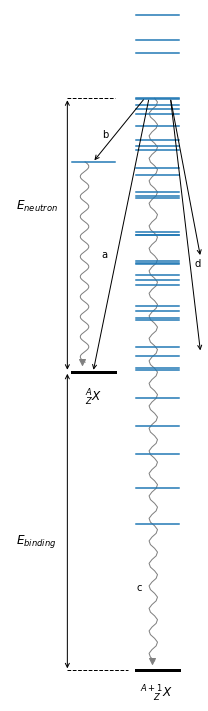

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,10))
for l in levels:
    if l>0.95*shift and l<1.2*shift:
        line=plt.Line2D([2,3],[l,l])
        ax.add_artist(line)

for l in levels23:
    line=plt.Line2D([0.5,1.5],[shift+l,shift+l])
    ax.add_artist(line)

#gs A
line=plt.Line2D([0.5,1.5],[shift,shift],lw=3.0,c='k')
ax.add_artist(line)
plt.annotate(r'${}^A_ZX}$',(0.8,shift*0.991),fontsize=12)

#gs A+1
line=plt.Line2D([2,3],[0.91*shift,0.91*shift],lw=3.0,c='k')
ax.add_artist(line)
line=plt.Line2D([0.4,1.8],[0.91*shift,0.91*shift],lw=1.0,c='k',ls='--')
ax.add_artist(line)
plt.annotate(r'${}^{A+1}_{\:\:\:\:\:\:\:Z}X}$',(2.1,shift*0.91*0.991),fontsize=12)

plt.annotate(s='', xy=(0.4,shift), xytext=(0.4,0.91*shift), arrowprops=dict(arrowstyle='<->'))
plt.annotate(r'$E_{binding}$',(-0.8,6600),fontsize=12)

#Excited
line=plt.Line2D([0.4,1.5],[7533,7533],lw=1.0,c='k',ls='--')
ax.add_artist(line)
plt.annotate(s='', xy=(0.4,7533), xytext=(0.4,shift), arrowprops=dict(arrowstyle='<->'))
plt.annotate(r'$E_{neutron}$',(-0.8,7300),fontsize=12)

#paths
#elastic
plt.annotate(s='', xy=(2.3,7533), xytext=(1.0,shift), arrowprops=dict(arrowstyle='<-'))
#inelastic
plt.annotate(s='', xy=(2.2,7533), xytext=(1.0,shift+440.2), arrowprops=dict(arrowstyle='<-'))
patch=curly_arrow((0.8, shift+440.2), (0.8, shift+20), n=10, arr_size=.0)
ax.add_patch(patch)
plt.scatter([0.75],[shift+20],marker='v',color='gray')
#radiative capture
patch=curly_arrow((2.4, 7533), (2.4, 0.91*shift+20), n=25, arr_size=.0)
ax.add_patch(patch)
plt.scatter([2.38],[0.91*shift+20],marker='v',color='gray')
#fission
plt.annotate(s='', xy=(2.8,7533), xytext=(3.5,7000), arrowprops=dict(arrowstyle='<-'))
plt.annotate(s='', xy=(2.8,7533), xytext=(3.5,7200), arrowprops=dict(arrowstyle='<-'))
#captions
plt.annotate(s='a', xy=(1.2,7200))
plt.annotate(s='b', xy=(1.2,7450))
plt.annotate(s='c', xy=(2.0,6500))
plt.annotate(s='d', xy=(3.35,7180))

plt.xlim(-1.0,3.5)
plt.ylim(0.9*shift,1.11*shift)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axis('off')
plt.tight_layout()
#plt.savefig('01-reactionlevels.png',dpi=300)
plt.show()

## Cross sections <a name="xs"></a>

### H1 elastic

notice how flat it is at mid energies.

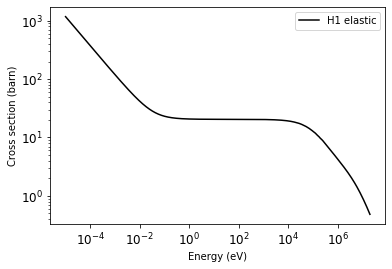

In [28]:
website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,1,1,125,3,2'
with urllib.request.urlopen(website) as response:
    content = response.readlines()
    
energy,xs=getXS(content)

plt.figure()
plt.loglog(energy,xs,'k',label='H1 elastic')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (barn)')
plt.legend()
#plt.savefig('01-H1scattering.png',dpi=300)
plt.show()


### C12 inelastic

notice threshold.

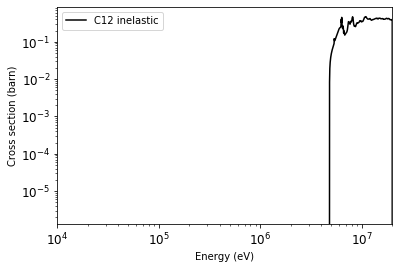

In [29]:
website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=endfb8.0,6,12,625,3,4'

with urllib.request.urlopen(website) as response:
    content = response.readlines()
    
energy,xs=getXS(content)

plt.figure()
plt.loglog(energy,xs,'k',label='C12 inelastic')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (barn)')
plt.legend()
plt.xlim(1e4,2e7)
#plt.savefig('01-c12inelastic.png')
plt.show()

### U238 elastic

notice interferance effects.

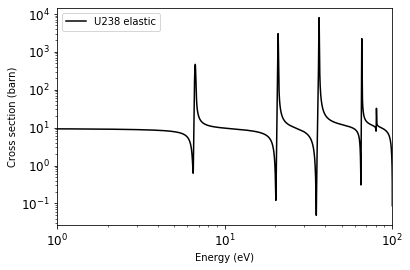

In [30]:
website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,238,9237,3,2'

with urllib.request.urlopen(website) as response:
    content = response.readlines()
    
energy,xs=getXS(content)

plt.figure()
plt.loglog(energy,xs,'k',label='U238 elastic')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (barn)')
plt.legend()
plt.xlim(1,1e2)
#plt.savefig('01-u238-resonancescatter.png',dpi=300)
plt.show()

### U238 capture

notice various parts. 1/v, resonancse, URR, then at high energies flat again, since we cannot resolve it at all.

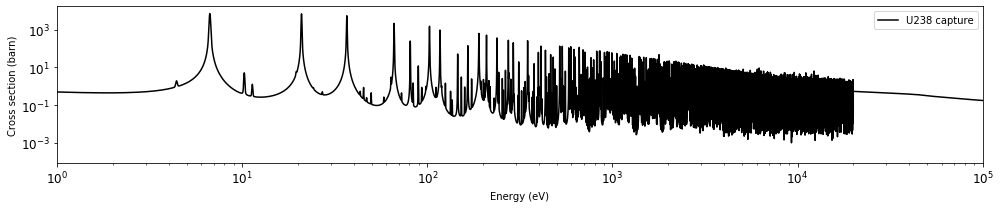

In [31]:
website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,238,9237,3,102'

with urllib.request.urlopen(website) as response:
    content = response.readlines()
    
energy,xs=getXS(content)
%matplotlib inline
plt.figure(figsize=(14,3))
plt.loglog(energy,xs,'k',label='U238 capture')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (barn)')
plt.legend()
plt.xlim(1,1e5)
plt.tight_layout()
#plt.savefig('01-u238-capture.png',dpi=300)
plt.show()

### U235 and U238 fission and total

notice threshold for U238.

/home/zsolt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


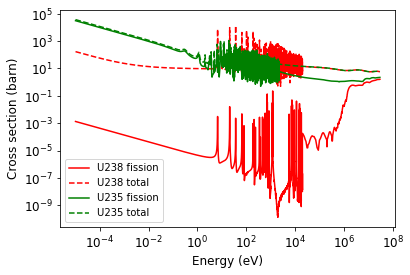

In [32]:
data={'U238 fission': {'Z':92, 'A':238,'MAT':9237,'MT':18,
                  'energy':[],'xs':[],'col':'r-'},
      'U238 total': {'Z':92, 'A':238,'MAT':9237,'MT':1,
                  'energy':[],'xs':[],'col':'r--'},
     'U235 fission': {'Z':92, 'A':235,'MAT':9228,'MT':18,
                  'energy':[],'xs':[],'col':'g-'},
      'U235 total': {'Z':92, 'A':235,'MAT':9228,'MT':1,
                  'energy':[],'xs':[],'col':'g--'}}

plt.figure()
for reaction in data:
    website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,%d,%d,%d,3,%d'% \
              (data[reaction]['Z'],data[reaction]['A'],data[reaction]['MAT'],data[reaction]['MT'])
    with urllib.request.urlopen(website) as response:
        content = response.readlines()
    energy,xs=getXS(content)
    data[reaction]['energy']=energy
    data[reaction]['xs']=xs
    plt.loglog(energy,xs,data[reaction]['col'],label=reaction)
plt.legend()
plt.xlabel('Energy (eV)',fontsize=12)
plt.ylabel('Cross section (barn)',fontsize=12)
#plt.savefig('01-Ufission.png',dpi=300)
plt.show()

## Scattering  <a name="scattering"></a>

The plots related to scattering reactions.

### Isotropic (in CM) elastic scattering

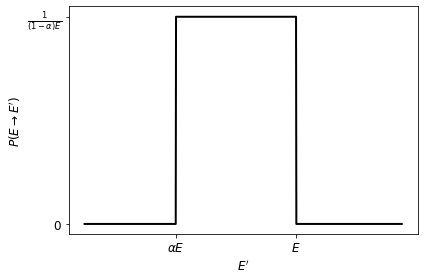

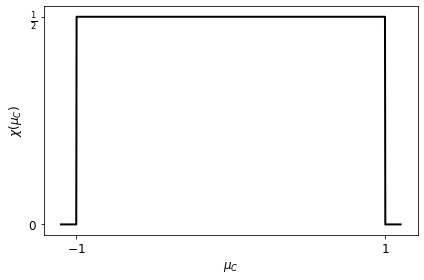

In [33]:
import numpy as np
import matplotlib.pyplot as plt

E=2
A=12
alpha=((A-1)/(A+1))**2

plt.figure()
energy=np.linspace(1.0,2.5,1000)
pdf=[1/((1-alpha)*E) if (ei>=alpha*E and ei<=E) else 0 for ei in energy]
plt.xlabel("$E'$",fontsize=12)
plt.ylabel(r"$P(E \rightarrow E')$",fontsize=12)
plt.xticks([alpha*E,E],[r'$\alpha E$',r'$E$'],fontsize=12)
plt.yticks([0,1/((1-alpha)*E)],[r'$0$',r'$\frac{1}{(1-\alpha)E}$'],fontsize=12)
plt.plot(energy,pdf,'k',lw=2)
plt.tight_layout()
#plt.savefig('01-elastickernelpdf.png',dpi=300)
plt.show()

plt.figure()
muc=np.linspace(-1.1,1.1,1000)
pdf=pdf=[1/2 if (m>=-1.0 and m<=1.0) else 0 for m in muc]
plt.xlabel("$\mu_C$",fontsize=12)
plt.ylabel(r"$\chi(\mu_C)$",fontsize=12)
plt.xticks([-1.0,1.0],[r'$-1$',r'$1$'],fontsize=12)
plt.yticks([0,1/2],[r'$0$',r'$\frac{1}{2}$'],fontsize=12)
plt.plot(muc,pdf,'k',lw=2)
plt.tight_layout()
#plt.savefig('01-isotropmucpdf.png',dpi=300)
plt.show()



### Validity of isotropy in CM

Several books, such as D&H, mentions that the average scattering cosine in CM can be given as 

$$\mu_c=0.07 A^{2/3} E[MeV]$$

although the cosine being zero does not necessarily mean that the distribution of the cosine is uniform, but it is still worth to visualize in which regions this cosine is less then some threshold (0.01 in this example), to illustrate the energy and nuclide mass range when isotropy is a fairly acceptable assumption.


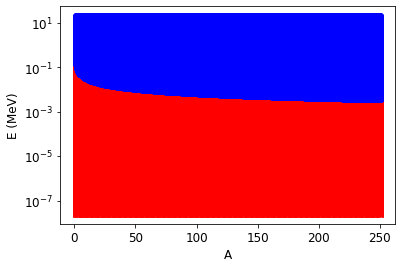

In [34]:
import numpy as np
import matplotlib.pyplot as plt

As=np.linspace(1,250,250)
Es=np.logspace(np.log10(0.025e-6),np.log10(20),1000)

eps=0.01

Avalid=[]
Evalid=[]

Anotvalid=[]
Enotvalid=[]

for A in As:
    for E in Es:
        muc=0.07*A**(2/3)*E
        if abs(muc)<=eps:
            Avalid.append(A)
            Evalid.append(E)
        else:
            Anotvalid.append(A)
            Enotvalid.append(E)
        
plt.figure()
plt.semilogy(Avalid,Evalid,'rx')
plt.semilogy(Anotvalid,Enotvalid,'bo')
plt.xlabel('A',fontsize=12)
plt.ylabel('E (MeV)',fontsize=12)
#plt.savefig('01-CoMisotropy.png',dpi=300)
plt.show()        

### Thermal scattering kernel

First one is implemented from the D&H book.

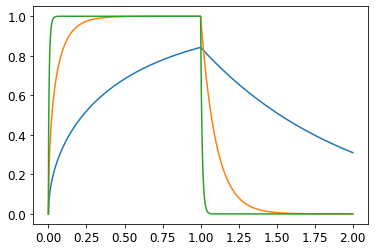

In [35]:
from scipy.special import erf
def scatteringKernel(Ei,Efs,T):
    k=8.617333262145E-5
    sig=1#np.interp(Ei,energy,xs)
    ps=[]
    for Ef in Efs:
        if Ef<=Ei:
            p=sig/Ei*erf(np.sqrt(Ef/k/T))
        else:
            p=sig/Ei*np.exp((Ei-Ef)/k/T)*erf(np.sqrt(Ei/k/T))
        ps.append(p)
    return np.array(ps)/sig*Ei
    
k=8.617333262145E-5
plt.figure()
Ep=np.linspace(0,2*k*300,10000)
plt.plot(Ep/(1*k*300),scatteringKernel(1*k*300,Ep,300))
Ep=np.linspace(0,20*k*300,10000)
plt.plot(Ep/(10*k*300),scatteringKernel(10*k*300,Ep,300))
Ep=np.linspace(0,200*k*300,10000)
plt.plot(Ep/(100*k*300),scatteringKernel(100*k*300,Ep,300))
plt.show()            

The second is from the book of Szathmary (https://oktatok.reak.bme.hu/kdp/wp-content/uploads/sites/19/2019/09/Bevrf.pdf)

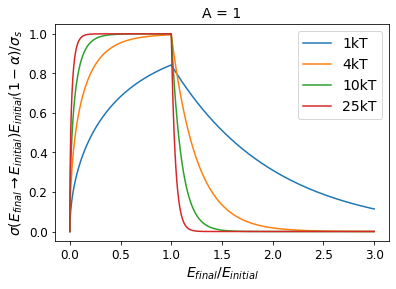

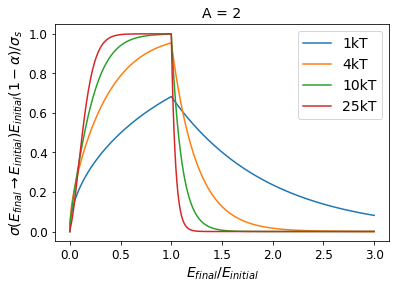

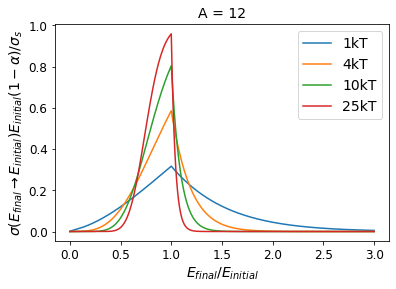

In [36]:
from scipy.special import erf
import matplotlib.pyplot as plt
import numpy as np
def scatteringKernel(Ep,Es,A=1,T=300):
#Ep->Es
    k=8.617333262145E-5
    eta=(A+1)/(2*np.sqrt(A))
    rho=(A-1)/(2*np.sqrt(A))
    alpha=((A-1)/(A+1))**2
    ps=[]
    for E in Es:
        if E<=Ep:
            p1=1/(2*Ep)*eta**2*(erf(eta*np.sqrt(E/k/T)-rho*np.sqrt(Ep/k/T))+
                                erf(eta*np.sqrt(E/k/T)+rho*np.sqrt(Ep/k/T)))
            p2=1/(2*Ep)*eta**2*np.exp(-(E-Ep)/k/T)* \
                               (erf(eta*np.sqrt(Ep/k/T)-rho*np.sqrt(E/k/T))-
                                erf(eta*np.sqrt(Ep/k/T)+rho*np.sqrt(E/k/T)))
            p=p1+p2
            ps.append(p)
        else:        
            p1=1/(2*Ep)*eta**2*(erf(eta*np.sqrt(E/k/T)-rho*np.sqrt(Ep/k/T))-
                                erf(eta*np.sqrt(E/k/T)+rho*np.sqrt(Ep/k/T)))
            p2=1/(2*Ep)*eta**2*np.exp(-(E-Ep)/k/T)* \
                               (erf(eta*np.sqrt(Ep/k/T)-rho*np.sqrt(E/k/T))+
                                erf(eta*np.sqrt(Ep/k/T)+rho*np.sqrt(E/k/T)))
            p=p1+p2
            ps.append(p)
    return np.array(ps)*Ep*(1-alpha) #sig_s is not included from the beginning, hence no need to divide with it

%matplotlib inline
k=8.617333262145E-5
T=1200

for Ai in [1,2,12]:
    plt.figure()
    for i in [1,4,10,25]:
        Ef=np.linspace(0,3*i*k*T,1000)
        Ei=i*k*T
        plt.plot(Ef/Ei,scatteringKernel(Ei,Ef,A=Ai,T=T),label='{}kT'.format(i))
    plt.title('A = '+str(Ai),fontsize=14)
    plt.legend(fontsize=14)
    plt.xlabel(r'$E_{final}/E_{initial}$',fontsize=14)
    plt.ylabel(r'$\sigma(E_{final}\rightarrow E_{initial})E_{initial}(1-\alpha)/\sigma_s$',fontsize=14)
    plt.savefig('01-thermalscatteringkernel%d.png'%Ai,dpi=300)
    plt.show()


## Doppler-effect <a name="doppler"></a>


The following formulae is implemented from the article "PINSPEC: A MONTE CARLO CODE FOR PIN CELL SPECTRAL CALCULATIONS FOR EDUCATIONAL APPLICATIONS" by W. Boyd et all (Proceedings of Physor 2014).

However, the model is not exactly implemented, and is intended to be used only for illustration, the actual values are not physically correct.

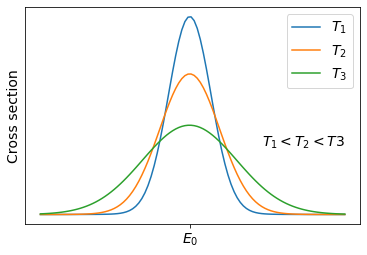

In [37]:
import numpy as np
from scipy import special

Gamma=1.493e-3
Gammag=23e-3
def resonance(E,E0=6.67,Gamma=1.493e-3,Gammag=23e-3,A=238,T=300):
    k=8.617333262145E-5
    h=4.135667696E-15
    xi=Gamma*np.sqrt(A/(4*k*T*E0))
    x=2*(E-E0)/Gamma
    #r=h**2/(2*np.pi)/E0*(A+1)/A
    r=2603911/E0*(A+1)/A
    Psi=np.real(xi*np.sqrt(np.pi)/2*special.wofz((x+np.complex(0,1))/2*xi))
    sigma=Gammag/Gamma*np.sqrt(E0/E)*r*Psi
    return sigma

energy=np.linspace(6.4,6.95,100)
import matplotlib.pyplot as plt
plt.figure()

for i,T in enumerate([300,600,1500]):
    plt.plot(energy,resonance(energy,T=T),label=r'$T_{}$'.format(i+1))
plt.legend(fontsize=14)
plt.xticks([6.67],[r'$E_0$'],fontsize=14)
plt.yticks([])
plt.ylabel('Cross section',fontsize=14)
plt.annotate(r'$T_1<T_2<T3$',(6.8,50000),fontsize=14)
#plt.savefig('01-doppler.png',dpi=300)
plt.show()

## Fission <a name="fission"></a>

Plots related to nuclear fission.

Here we rely on some data from IAEA NDS, files are attached.

### 3D fission yield

/home/zsolt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


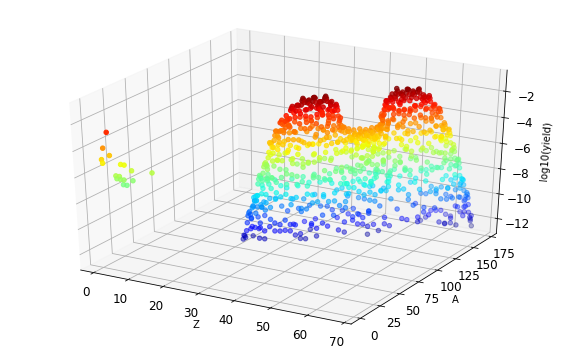

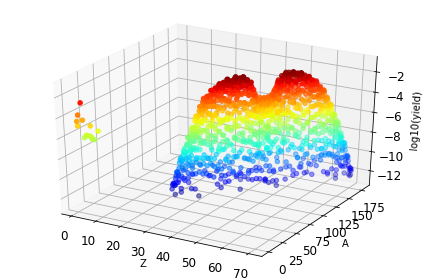

In [38]:
import pandas as pd
yielddf=pd.read_csv('fissionyieldU235.csv',header=0, usecols=['Z daughter',' A daughter',' independent thermal FY jeff3.1.1'])
yielddf = yielddf[yielddf[' independent thermal FY jeff3.1.1'] != ' '].astype(float)

yielddf239=pd.read_csv('fissionyieldPu239.csv',header=0, usecols=['Z daughter',' A daughter',' independent thermal FY jeff3.1.1'])
yielddf239 = yielddf239[yielddf239[' independent thermal FY jeff3.1.1'] != ' '].astype(float)


from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(yielddf['Z daughter'], yielddf[' A daughter'], np.log10(yielddf[' independent thermal FY jeff3.1.1']), 
                     c=np.log10(yielddf[' independent thermal FY jeff3.1.1']), cmap='jet')
ax.set_xlabel('Z')
ax.set_ylabel('A')
ax.set_zlabel('log10(yield)')
plt.tight_layout()
#plt.savefig('01-fissionyield3d-U235.png',dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(yielddf239['Z daughter'], yielddf239[' A daughter'], np.log10(yielddf239[' independent thermal FY jeff3.1.1']), 
                     c=np.log10(yielddf239[' independent thermal FY jeff3.1.1']), cmap='jet')
ax.set_xlabel('Z')
ax.set_ylabel('A')
ax.set_zlabel('log10(yield)')
plt.tight_layout()
plt.show()

### 2D yield

this requires the cell above, since the same data is used.

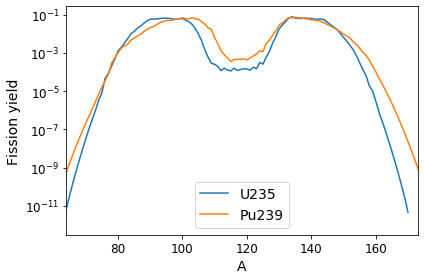

In [39]:
reduceddf=yielddf.groupby(' A daughter').sum()
reduceddf239=yielddf239.groupby(' A daughter').sum()

plt.figure()
plt.semilogy(reduceddf.index,reduceddf[' independent thermal FY jeff3.1.1'],label='U235')
plt.semilogy(reduceddf239.index,reduceddf239[' independent thermal FY jeff3.1.1'],label='Pu239')
plt.xlim(64,173)
plt.legend(loc='lower center',fontsize=14)
plt.ylabel('Fission yield',fontsize=14)
plt.xlabel('A',fontsize=14)
plt.tight_layout()
#plt.savefig('01-fissionyield2d.png',dpi=300)
plt.show()

### Watt-spectrum

with the values and function given in the lecture note.

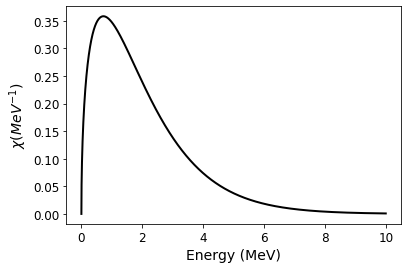

In [40]:
def watt(x):
    C1 = 0.453
    C2 = 0.965
    C3 = 2.29
    return C1*np.exp(-x/C2)*np.sinh(np.sqrt(C3*x))
                                
E=np.linspace(0,10,10000)
plt.plot(E,watt(E),'k',lw=2)
plt.xlabel('Energy (MeV)',fontsize=14)
plt.ylabel(r'$\chi (MeV^{-1})$',fontsize=14)
#plt.savefig('01-watt.png',dpi=300)
plt.show()

### Distribution of number neutrons from fission

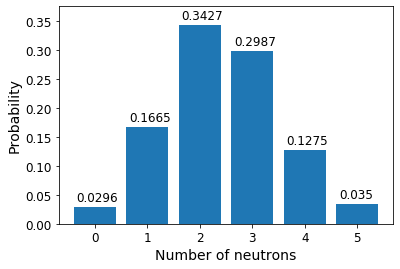

In [41]:
nu=[0,1,2,3,4,5]
pnu=[0.0296,0.1665,0.3427,0.2987,0.1275,0.035]

plt.figure()
plt.bar(nu,pnu)
plt.xlabel('Number of neutrons', fontsize=14)
plt.ylabel('Probability',fontsize=14)
for n,p in zip(nu,pnu):
    plt.annotate(str(p),[n-0.35,p+.01], fontsize=12)
plt.ylim(0.0,0.375)
#plt.savefig('01-nu.png',dpi=300)
plt.show()

### nubar energy dependence

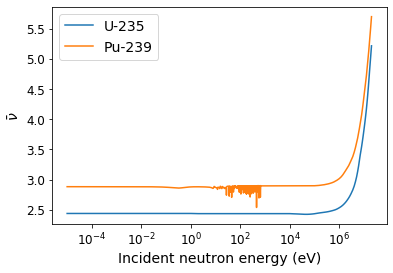

In [42]:
import numpy as np
u235nubar = np.loadtxt('u235nubar.csv', skiprows=3,delimiter=';') # Use skiprows to skip header lines
pu239nubar = np.loadtxt('pu239nubar.csv', skiprows=3,delimiter=';') # Use skiprows to skip header lines

import matplotlib.pyplot as plt

plt.figure()
plt.semilogx(u235nubar[:,0],u235nubar[:,1],label='U-235')
plt.semilogx(pu239nubar[:,0],pu239nubar[:,1],label='Pu-239')
plt.xlabel('Incident neutron energy (eV)',fontsize=14)
plt.ylabel(r'$\bar\nu$',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('01-nubar.png',dpi=300)
plt.show()


### Various other XS plots and $\eta(E)$ plot

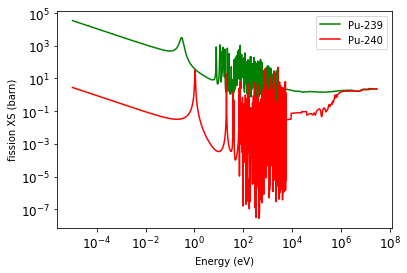

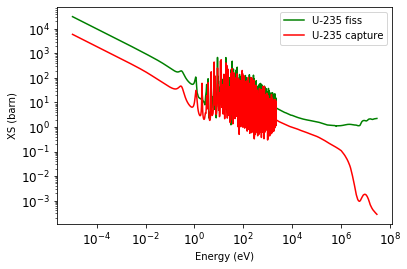

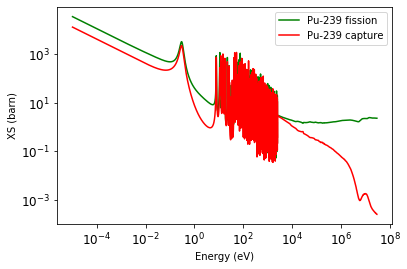

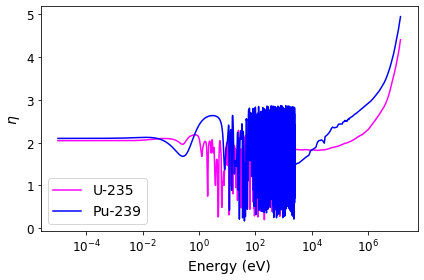

In [43]:
### FISSILE VS FERTILE PU ###

website239='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,94,239,9437,3,18'
website240='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,94,240,9440,3,18'

with urllib.request.urlopen(website239) as response:
    content239 = response.readlines()
energy239,xs239=getXS(content239)

with urllib.request.urlopen(website240) as response:
    content240 = response.readlines()
energy240,xs240=getXS(content240)

plt.figure()
plt.loglog(energy239,xs239, 'g', label='Pu-239')
plt.loglog(energy240,xs240, 'r', label='Pu-240')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('fission XS (barn)')
#plt.savefig('puxs.png',dpi=300)
plt.show()


### XS FOR ETA PLOT ###

website235f='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'
website235c='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,102'

with urllib.request.urlopen(website235f) as response:
    content235f = response.readlines()
energy235f,xs235f=getXS(content235f)

with urllib.request.urlopen(website235c) as response:
    content235c = response.readlines()
energy235c,xs235c=getXS(content235c)

plt.figure()
plt.loglog(energy235f,xs235f, 'g', label='U-235 fiss')
plt.loglog(energy235c,xs235c, 'r', label='U-235 capture')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('XS (barn)')
#plt.savefig('u235xs.png',dpi=300)
plt.show()

# U238 capture


website239f='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,94,239,9437,3,18'
website239c='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,94,239,9437,3,102'

with urllib.request.urlopen(website239f) as response:
    content239f = response.readlines()
energy239f,xs239f=getXS(content239f)

with urllib.request.urlopen(website239c) as response:
    content239c = response.readlines()
energy239c,xs239c=getXS(content239c)

plt.figure()
plt.loglog(energy239f,xs239f, 'g', label='Pu-239 fission')
plt.loglog(energy239c,xs239c, 'r', label='Pu-239 capture')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('XS (barn)')
#plt.savefig('pu239xs.png',dpi=300)
plt.show()


######ETA PLOT####

nubar235=np.interp(energy235f,u235nubar[:,0],u235nubar[:,1])
xs235cN=np.interp(energy235f,energy235c,xs235c)
xs235a=xs235f+xs235cN
eta235=nubar235*xs235f/xs235a

nubar239=np.interp(energy239f,pu239nubar[:,0],pu239nubar[:,1])
xs239cN=np.interp(energy239f,energy239c,xs239c)
xs239a=xs239f+xs239cN
eta239=nubar239*xs239f/xs239a

plt.figure()
plt.semilogx(energy235f[:-50],eta235[:-50],'magenta',label='U-235')
plt.semilogx(energy239f[:-50],eta239[:-50],'blue',label='Pu-239')
plt.legend()
plt.xlabel('Energy (eV)',fontsize=14)
plt.ylabel(r'$\eta$',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=14,loc=3,frameon=True)
plt.tight_layout()
#plt.savefig('01-PuUeta.png',dpi=300)
plt.show()

# Fission chain reactions and neutron spectrum <a name="fissionchainspectrum"></a>

All the figures from the 3rd chapter of the notes

## Critical fission trees <a name="trees"></a>

since the images are random, it is not possible to recreate the exact same figures as in the notes.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
class Neutron(object):
    """A neutron object
    
    Attributes
    ----------
    x : float
        x-coordinate of neutron on the plot (which is basically the index of the generation it belongs to)
    y : float
        y-coordinate of neutron on the plot (this is a rather arbitrary number)
    dead : bool
        Bool to decide whether the neutron have died in a reaction not producing further neutrons
    parent : Neutron() object
        The parent of the neutron
    """
    def __init__(self,x=0.0,y=0.0,parent=None):
        self.id=None
        self.x=x
        self.y=y
        self.dead=False
        self.parent=parent

class Tree(object):
    """Random neutron tree object. Attributes are not documented here. 
    
    Parameters
    ----------
    p : float
        Probability that a neutron survives
    nufiss : tuple
        Is the probability distribution of the number of neutrons created in fission.
        Should be a tuple of two lists (first giving the number of neutrons after fission
        and the second giving the probabilities)
    nstart : int
        Number of orignal neutrons
    ngen : int
        Number of generations to follow
    yshift : float
        distance of neutrons on the plot in the y direction.
    """
    def __init__(self,p,nufiss,nstart,ngen,yshift=0.5):
        self.p=p
        self.nufiss=nufiss
        self.nstart=nstart
        self.ngen=ngen
        self.yshift=yshift
        self.generations=[[] for _ in range(ngen)]
        self.generations[0]=[Neutron() for i in range(nstart)]
        
    def run(self):
        """Function to generate random neutron trees"""
        for i in range(self.ngen-1):
            for neutron in self.generations[i]:
                r=np.random.random()
                if self.p>r: #then it survives
                    newBorn=np.random.choice(nufiss[0],p=nufiss[1])
                    if newBorn==0: #then essentially it dies
                        neutron.dead=True
                    else:
                        for _ in range(newBorn):
                            newNeutron=Neutron(x=i+1,parent=neutron) #x is essentially the related generation's number
                                                                     #if one would assume the time also x could reflect that
                            self.generations[i+1].append(newNeutron)
                else: #then it dies
                    neutron.dead=True

    def plot(self,showDead=True,aligned=False,out=None):
        """Function to plot random neutron trees"""
        plt.figure()
        for batch in self.generations[:-1]:#in the last batch all neutrons are still alive, so we don't plot them
            for i,neutron in enumerate(batch): 
                if aligned:
                    #if neutron.parent is None: #TODO can be elif
                    neutron.y=i*self.yshift-len(batch)*self.yshift/2
                    #else:
                    #    neutron.y=i*self.yshift-len(batch)*self.yshift/2+neutron.parent.y
                else:
                    neutron.y=i*self.yshift
                    
                if showDead and neutron.dead:
                    plt.plot(neutron.x,neutron.y,'rx')
                    if neutron.parent is not None:
                        plt.annotate(s='', xy=(neutron.parent.x,neutron.parent.y), 
                                 xytext=(neutron.x,neutron.y), arrowprops=dict(arrowstyle='<-'))
                if (not neutron.dead):# or (neutron.parent is None):#TODO elif: if parent none and dead, elif none elif dead showdead, else
                    plt.plot(neutron.x,neutron.y,'ko')
                    if neutron.parent is not None:
                        plt.annotate(s='', xy=(neutron.parent.x,neutron.parent.y), 
                                 xytext=(neutron.x,neutron.y), arrowprops=dict(arrowstyle='<-'))
        plt.yticks([])
        if out is not None:
            plt.savefig(out,dpi=300)
        plt.show()

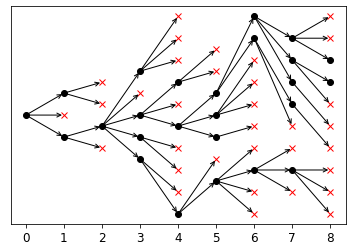

In [48]:
nu=[0,1,2,3,4,5]
pnu=[0.0296,0.1665,0.3427,0.2987,0.1275,0.035]
nufiss=(nu,pnu)

tree=Tree(0.42,nufiss,ngen=10,nstart=1) #somewhat supercritical. p=0.411 is the critical value.
tree.run()
tree.plot(aligned=True,showDead=True)
#tree.plot(aligned=True,out='02-randomtreeF.png')

## Simple kinetics <a name="simplekinetics"></a>


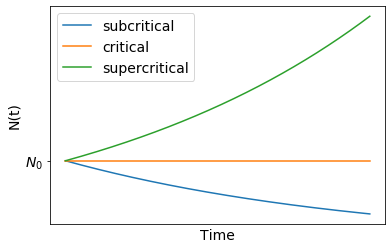

In [49]:
import numpy as np
import matplotlib.pyplot as plt

N0=1
ks=[0.99999,1, 1.00001]
labels=['subcritical','critical','supercritical']
l=1e-4 #s
time=np.linspace(0,10,1000)
plt.figure()
for k,la in zip(ks,labels):
    plt.plot(time,N0*np.exp((k-1)/l*time),label=la)

plt.xlabel('Time',fontsize=14)
plt.ylabel('N(t)',fontsize=14)
plt.xticks([])
plt.yticks([N0],[r'$N_0$'],fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('02-basickinetics.png',dpi=300)
plt.show()
    

## Slowing down and spectrum <a name="spectrum"></a>


### Illustration of energy vs lethargy change

here I first assume an average energy loss on Hydrogen. Since on hydrogen the outgoing neutron LAB  energy is uniformly distributed between 0 and $E_{in}$, the expected value of the outgoing energy is simply 

$E_{out}=E_{in}-E_{in}/2$

Here we simply evaluate this until a neutron reaches thermal energies from an orignal energy of 2MeV.

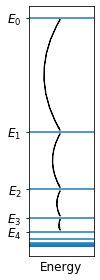

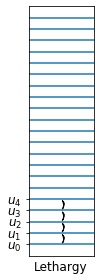

In [50]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
style = "Simple, tail_width=0.3, head_width=1, head_length=3"
kw = dict(arrowstyle=style, color="k")


plt.figure(figsize=(1.5,4))
E=2#MeV
u=np.log(2/E)
alpha=0
while E>1e-6:
    plt.axhline(E)
    E=E-E/2
    u=np.log(2/E)
plt.xticks([])
plt.yticks([2.0,1.0,0.5,0.25,0.125],[r'$E_%d$'%i for i in range(5)],fontsize=12)
plt.xlabel('Energy',fontsize=12)
arrows=[]
for ei,ef in zip([2.0,1.0,0.5,0.25],[1.0,0.5,0.25,0.125]):
    arrows.append(patches.FancyArrowPatch((0.5, ei), (0.5, ef),
                             connectionstyle="arc3,rad=0.3", **kw))
for a in arrows:
    plt.gca().add_patch(a)
plt.tight_layout()
#plt.savefig('03-energychange.png',dpi=300)
plt.show()

plt.figure(figsize=(1.5,4))
E=2#MeV
u=np.log(2/E)
alpha=0
while E>1e-6:
    plt.axhline(u)
    E=E-E/2
 

    u=np.log(2/E)
plt.xticks([])
plt.yticks([np.log(2/2.0),np.log(2/1.0),np.log(2/0.5),np.log(2/0.25),np.log(2/0.125)],[r'$u_%d$'%i for i in range(5)],fontsize=12)
plt.xlabel('Lethargy',fontsize=12)
arrows=[]
for ei,ef in zip([np.log(2/2.0),np.log(2/1.0),np.log(2/0.5),np.log(2/0.25)],
                 [np.log(2/1.0),np.log(2/0.5),np.log(2/0.25),np.log(2/0.125)]):
    arrows.append(patches.FancyArrowPatch((0.5, ei), (0.5, ef),
                             connectionstyle="arc3,rad=0.5", **kw))
for a in arrows:
    plt.gca().add_patch(a)
plt.tight_layout()
#plt.savefig('03-lethargychange.png',dpi=300)
plt.show()
    

### Illustration of energy vs lethargy change (realistic)

Although, the previous figure is very pedagogic, but it might be misleading, since it represents the average change in energy and lethargy for a large amount of neutrons. It can be interesting to look at the more generic case, where the outgoing energy is sampled randomly between $[\alpha E, E]$:

`E=np.random.uniform(alpha*E,E)`

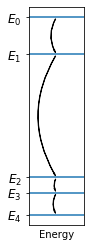

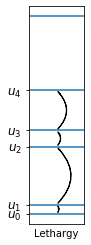

In [51]:
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
style = "Simple, tail_width=0.3, head_width=1, head_length=3"
kw = dict(arrowstyle=style, color="k")


plt.figure(figsize=(1,4))
E=2#MeV
Ei=E
Ef=0.1
u=np.log(2/E)
alpha=0.2
Es=[E]
us=[u]
while E>Ef:
    plt.axhline(E)
    E=np.random.uniform(alpha*E,E)
    u=np.log(2/E)
    Es.append(E)
    us.append(u)
plt.xticks([])
plt.yticks(Es[:5],[r'$E_%d$'%i for i in range(5)])
plt.annotate(s='', xy=(0,0), xytext=(0,2.1), arrowprops=dict(arrowstyle='<-'))
plt.xlabel('Energy')
arrows=[]
for ei,ef in zip(Es[:4],Es[1:5]):
    arrows.append(patches.FancyArrowPatch((0.5, ei), (0.5, ef),
                             connectionstyle="arc3,rad=0.3", **kw))
for a in arrows:
    plt.gca().add_patch(a)
#plt.savefig('03-energychange.png',dpi=300)
plt.show()

plt.figure(figsize=(1,4))
for u in us:
    plt.axhline(u)
plt.xticks([])
plt.yticks(us[:5],[r'$u_%d$'%i for i in range(5)])
plt.xlabel('Lethargy')
arrows=[]
for ei,ef in zip(us[:4],
                 us[1:5]):
    arrows.append(patches.FancyArrowPatch((0.5, ei), (0.5, ef),
                             connectionstyle="arc3,rad=0.5", **kw))
for a in arrows:
    plt.gca().add_patch(a)
#plt.savefig('03-lethargychange.png',dpi=300)
plt.show()
    

## Idealized neutron spectrum

We construct here the neutron spectrum from Maxwell, 1/E and Watt and visualize both the spectrum and the lethargic spectrum.

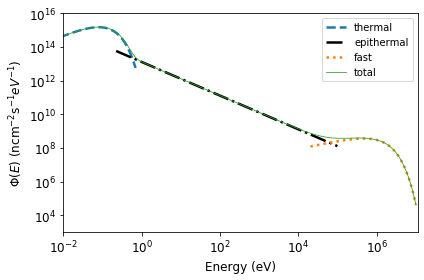

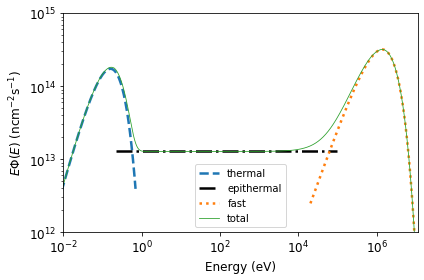

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def getSpectrum(energy):
    """Approximating the spectrum as in NIMA Vol 593 pp510-518 paper. 
    Constants describing the flux are taken from the same paper"""
    #thermal
    fth=[]
    k=8.6173324e-5 #eV/K
    T=925 #K
    for E in energy:
        fth.append(E*np.exp(-E/(k*T)))   #who needs pythonic way?
    energy=np.array(energy)
    fth=np.array(fth)
    fth=fth/np.trapz(fth,energy) #normalize
    
    #epithermal
    fepi=[]
    E0=0
    E1=0.2
    E2=0.25e6
    E3=1e6
    for E in energy:
        if E0<=E and E<E1:
            fepi.append((E**2-E0**2)/(E*(E1**2-E0**2)))
        elif E1<=E and E<E2:
            fepi.append(1/E)
        elif E2<=E and E<E3:
            fepi.append((E**2-E3**2)/(E*(E2**2-E3**2)))
        else:
            fepi.append(0.0)
    fepi=np.array(fepi)
    fepi=fepi/np.trapz(fepi,energy)
    
    #fast
    ffast=[]
    a=8.09e5 #u235 9.65e5
    b=9.32e-7 #u235 2.29e-6
    for E in energy:
        ffast.append(np.exp(-E/a)*np.sinh(np.sqrt(b*E)))
    ffast=np.array(ffast)
    ffast=ffast/np.trapz(ffast,energy)
    
    #create real spectrum
    PhiTh=3.2e14
    PhiEpi=1.98e14
    PhiFast=0.98e14*7
    
    phi=PhiTh*fth+PhiEpi*fepi+PhiFast*ffast
    #let's return all the components separetaly for plotting. But in practice "return phi" is enough
    return phi, PhiTh*fth,PhiEpi*fepi,PhiFast*ffast

energy=np.logspace(-6,7,1000) #in eV
spectrum,spectrumTh,spectrumEpi,spectrumFast=getSpectrum(energy)

mask=(energy>0.22)*(energy<1e5)
maskth=(energy<0.7)
maskf=(energy>0.2e5)
plt.ylim([1e3,1e16])
plt.xlim([1e-2,1.1e7])
plt.loglog(energy[maskth],spectrumTh[maskth],'--',lw=2.5,label='thermal')
plt.loglog(energy[mask],spectrumEpi[mask],'k-.',lw=2.5,label='epithermal')
plt.loglog(energy[maskf],spectrumFast[maskf],':',lw=2.5,label='fast')
plt.loglog(energy,spectrum,label='total',lw=0.8)
plt.legend()
plt.xlabel('Energy (eV)',fontsize=12)
plt.ylabel(r'$\Phi(E)$ (ncm$^{-2}$s$^{-1}eV^{-1}$)',fontsize=12)
plt.tight_layout()
#plt.savefig('03-theoryspectrum.png',dpi=300)
plt.show()

plt.ylim([1e3,1e16])
plt.xlim([1e-2,1.1e7])
plt.loglog(energy[maskth],energy[maskth]*spectrumTh[maskth],'--',lw=2.5,label='thermal')
plt.loglog(energy[mask],energy[mask]*spectrumEpi[mask],'k-.',lw=2.5,label='epithermal')
plt.loglog(energy[maskf],energy[maskf]*spectrumFast[maskf],':',lw=2.5,label='fast')
plt.loglog(energy,energy*spectrum,label='total',lw=0.8)
plt.legend()
plt.xlabel('Energy (eV)',fontsize=12)
plt.ylabel(r'$E\Phi(E)$ (ncm$^{-2}$s$^{-1}$)',fontsize=12)
plt.ylim(1e12,1e15)
plt.tight_layout()
#plt.savefig('03-theoryspectrumlet.png',dpi=300)
plt.show()

### Maxwell and Watt

Visualizing the Maxwell and Watt spectra separately.

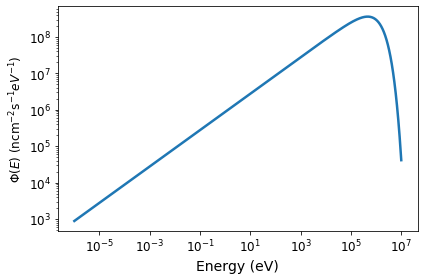

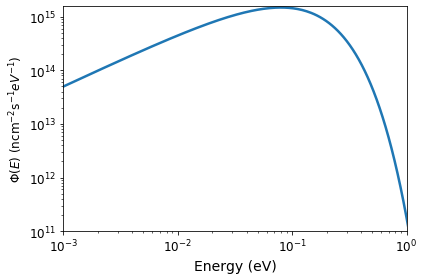

In [53]:
plt.figure()
plt.loglog(energy,spectrumFast,'-',lw=2.5,label='fast')
plt.xlabel('Energy (eV)',fontsize=14)
plt.ylabel(r'$\Phi(E)$ (ncm$^{-2}$s$^{-1}eV^{-1}$)',fontsize=12)
plt.tight_layout()
#plt.savefig('02-watt.png',dpi=300)
plt.show()

plt.figure()
plt.loglog(energy,spectrumTh,'-',lw=2.5,label='fast')
plt.xlabel('Energy (eV)',fontsize=14)
plt.ylabel(r'$\Phi(E)$ (ncm$^{-2}$s$^{-1}eV^{-1}$)',fontsize=12)
plt.xlim(1e-3,1e0)
plt.ylim(1e11,1.55e15)
plt.tight_layout()
#plt.savefig('02-maxwell.png',dpi=300)
plt.show()


## Realistic spectrum

Here we will use openMC to calculate the spectrum in a PWR fuelcell with reflective boundaries. The cell is rather long, since it requires the whole definition of the problem. This bit needs openMC to execute.

In [1]:
import openmc
import  numpy as np
import matplotlib.pyplot as plt

uo2 = openmc.Material(1, "uo2",temperature=1200)
# Add nuclides to uo2
uo2.add_nuclide('U235', 0.04)
uo2.add_nuclide('U238', 0.96)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.5)

zirconium = openmc.Material(2, "zirconium",temperature=900)
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.75)
water.add_s_alpha_beta('c_H_in_H2O')

mats = openmc.Materials([uo2, zirconium, water])
mats.export_to_xml()

fuel_or = openmc.ZCylinder(r=0.41)
clad_ir = openmc.ZCylinder(r=0.42)
clad_or = openmc.ZCylinder(r=0.45)

fuel_region = -fuel_or
gap_region = +fuel_or & -clad_ir
clad_region = +clad_ir & -clad_or

fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(2, 'air gap')
gap.region = gap_region

clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = clad_region

pitch = 1.26
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

water_region = +left & -right & +bottom & -top & +clad_or

moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = water_region

root = openmc.Universe(cells=(fuel, gap, clad, moderator))

geom = openmc.Geometry()
geom.root_universe = root
geom.export_to_xml()

point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 50000
settings.export_to_xml()

cell_filter = openmc.CellFilter(fuel)
energybins=np.logspace(-2,7,1000)
energy_filter = openmc.EnergyFilter(energybins)

t = openmc.Tally(1) #tally for mapping out the whole spectrum
t.filters = [cell_filter,energy_filter]

t.scores = ['flux']

t2 = openmc.Tally(2)  #tally for mapping out the 6.67 resonance
energybins2=np.linspace(5,50,500)
energy_filter2 = openmc.EnergyFilter(energybins2)
t2.filters = [cell_filter,energy_filter2]

t2.scores = ['flux']

tallies = openmc.Tallies([t,t2])
tallies.export_to_xml()

import os
os.system('rm s*h5')

os.environ['OPENMC_CROSS_SECTIONS']='/home/zsolt/xs_openmc/cross_sections.xml'
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

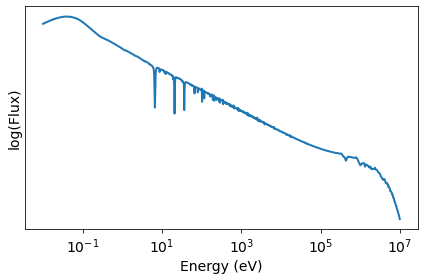

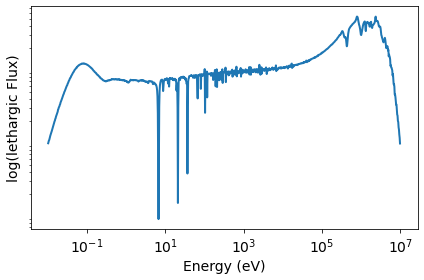

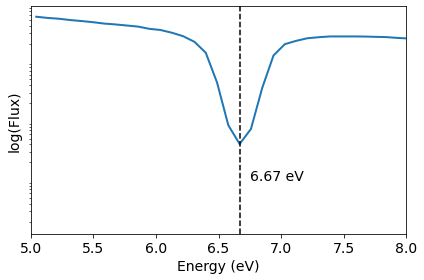

In [2]:
sp = openmc.StatePoint('statepoint.100.h5')
tallydf=sp.tallies[1].get_pandas_dataframe()
tallydf1=sp.tallies[2].get_pandas_dataframe()


plt.figure()
plt.loglog((tallydf['energy low [eV]']+tallydf['energy high [eV]'])/2,tallydf['mean']/((tallydf['energy low [eV]']+tallydf['energy high [eV]'])),lw=2)
plt.ylabel('log(Flux)',fontsize=14)
plt.xlabel('Energy (eV)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.tight_layout()
#plt.savefig('02-pwrspectrum.png',dpi=300)
plt.show()

plt.figure()
plt.loglog((tallydf['energy low [eV]']+tallydf['energy high [eV]'])/2,tallydf['mean'],lw=2)
plt
plt.ylabel('log(lethargic Flux)',fontsize=14)
plt.xlabel('Energy (eV)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.tight_layout()
#plt.savefig('02-pwrspectrumlethargic.png',dpi=300)
plt.show()

plt.figure()
plt.semilogy((tallydf1['energy low [eV]']+tallydf1['energy high [eV]'])/2,tallydf1['mean']/((tallydf1['energy low [eV]']+tallydf1['energy high [eV]'])),lw=2)
plt.xlim(5,8)
plt.axvline(6.67,ls='--',color='k')
plt.annotate('6.67 eV',(6.75,1e-6),fontsize=14)
plt.ylabel('log(Flux)',fontsize=14)
plt.xlabel('Energy (eV)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.tight_layout()
#plt.savefig('02-selfshielding.png',dpi=300)
plt.show()

## Neutron cycle <a name="neutroncycle"></a>


Any figure trying to summarize the neutron cycle in one image is usually messy, it is not different here. Nevertheless we gave it a try.

First we load in some cross sections used for the figure. Note that functions `getXS()` and `watt()` were defined earlier, here however we wanted to include all the functions needed for this figure at one place.

In [3]:
def watt(x):
    C1 = 0.453
    C2 = 0.965
    C3 = 2.29
    return C1*np.exp(-x/C2)*np.sinh(np.sqrt(C3*x))

def getXS(content):
    """Function to extract data from the html content provided by KAERI.
    the content has a shape as follows like:    
    Energy(eV) XS(b)<br>
    1.00000E-05 3.07139<br>"""
    energy=[]
    xs=[]
    flag=False
    i=0
    for line in content:
        x=line.strip().split()
        if  x[0]==b'Energy(eV)':
            flag=True
            continue
        if x[0]==b'</span>':
            flag=False
        if flag:
            energy.append(float(x[0]))
            xs.append(float(x[1][:-4]))
    return np.array(energy), np.array(xs)

import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

website238f='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,238,9237,3,18'

with urllib.request.urlopen(website238f) as response:
    content238f = response.readlines()
    
energy238f,xs238f=getXS(content238f)

websitezr='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,40,90,4025,3,102'
with urllib.request.urlopen(websitezr) as response:
    contentzr = response.readlines()
    
energyzr,xszr=getXS(contentzr)

websiteh='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,1,1,125,3,102'
with urllib.request.urlopen(websiteh) as response:
    contenth = response.readlines()
    
energyh,xsh=getXS(contenth)


website238c='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,238,9237,3,102'

with urllib.request.urlopen(website238c) as response:
    content238c = response.readlines()
    
energy238c,xs238c=getXS(content238c)

website235f='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'
website235c='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,102'

with urllib.request.urlopen(website235f) as response:
    content235f = response.readlines()
energy235f,xs235f=getXS(content235f)

with urllib.request.urlopen(website235c) as response:
    content235c = response.readlines()
energy235c,xs235c=getXS(content235c)

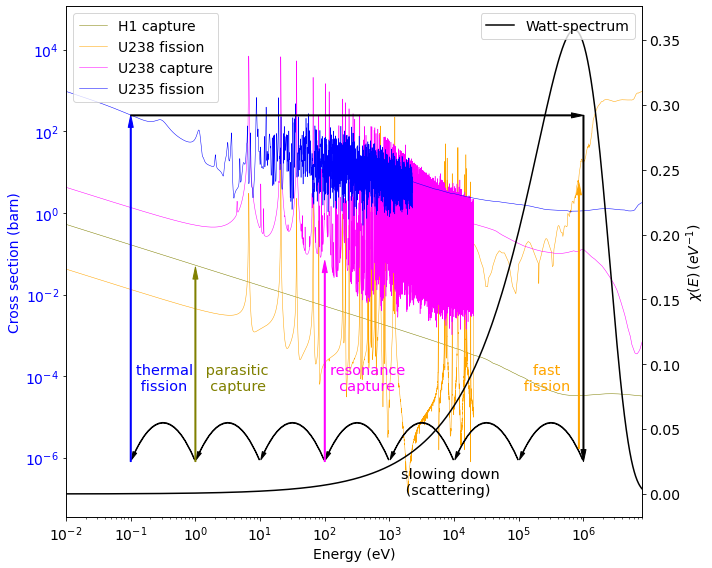

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# Create some mock data

fig, ax1 = plt.subplots(figsize=(10,8))

color = 'blue'
ax1.set_xlabel('Energy (eV)',fontsize=14)
ax1.set_ylabel('Cross section (barn)', color=color,fontsize=14)
ax1.loglog(energyh,xsh,color='olive',label='H1 capture',lw=0.5)
ax1.loglog(energy238f, 1000*xs238f, color='orange',label='U238 fission',lw=0.5)
ax1.loglog(energy238c, xs238c, color='magenta',label='U238 capture',lw=0.5)
ax1.loglog(energy235f, xs235f, color='blue',label='U235 fission',lw=0.5)

ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left',fontsize=14)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
ax2.set_ylabel(r'$\chi (E) \: (eV^{-1})$', color=color,fontsize=14)  # we already handled the x-label with ax1
ax2.semilogx(energy235c,watt(energy235c/1e6), color='black',label='Watt-spectrum')

ax2.tick_params(axis='y', labelcolor=color)

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
arrows=[]
for ei,ef in zip([1e6,1e5,1e4,1e3,1e2,1e1,1e0],[1e5,1e4,1e3,1e2,1e1,1e0,1e-1]):
    arrows.append(patches.FancyArrowPatch((ei, 0.025), (ef, 0.025),
                             connectionstyle="arc3,rad=1.2", **kw))
for a in arrows:
    plt.gca().add_patch(a)


plt.annotate(text='', xy=(8.5e5,0.24), 
                                 xytext=(8.5e5,0.035), arrowprops=dict(color='orange',width=1.0,headwidth=5))
plt.annotate(text='', xy=(1e2,0.18), 
                                 xytext=(1e2,0.025), arrowprops=dict(color='magenta',width=1.0,headwidth=5))
plt.annotate(text='', xy=(1e-1,0.292), 
                                 xytext=(1e-1,0.025), arrowprops=dict(color='blue',width=1.,headwidth=5)) 
plt.annotate(text='', xy=(1e0,0.175), 
                                 xytext=(1e0,0.025), arrowprops=dict(color='olive',width=1.,headwidth=5)) 
plt.annotate(text='', xy=(1e6,0.292), 
                                 xytext=(1e-1,0.292), arrowprops=dict(color='black',width=1, headwidth=5)) 
plt.annotate(text='', xy=(1e6,0.025), 
                                 xytext=(1e6,0.292), arrowprops=dict(color='black',width=1.,headwidth=5)) 
plt.annotate('thermal \n fission',(1.2e-1,0.08),color='blue',fontsize=14.5)
plt.annotate(' parasitic \n  capture',(1.2e0,0.08),color='olive',fontsize=14.5)
plt.annotate('resonance \n  capture',(1.2e2,0.08),color='magenta',fontsize=14.5)
plt.annotate('slowing down \n (scattering)',(1.5e3,0.0),color='black',fontsize=14.5)
plt.annotate('   fast \n fission',(1e5,0.08),color='orange',fontsize=14.5)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xlim(1e-2,8e6)
plt.legend(loc='upper right',fontsize=14)
#plt.savefig('03-neutroncycle.png',dpi=300)
plt.show()

# Neutron transport and diffusion  <a name="transport"></a>

In the following we present all the figures related to neutron transport and diffusion in the lecture notes and in the lectures.


## Transport vs diffusion at boundaries <a name="transportvsdiffusion"></a>


here we create a homogeneous U-H2O Slab reactor with openMC, and map the flux in space. Then we fit a cosine to the flux in the mid core region, and consider that as the diffiusion solution.


In [6]:
import openmc
import  numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs

fuelm = openmc.Material(1,"uo2")
fuelm.set_density('g/cm3', 10.31341)
fuelm.add_nuclide('U235', 3.7503e-4) #from 3.7503e-4
fuelm.add_nuclide('U238', 2.2625e-2)
fuelm.add_nuclide('O16', 4.6007e-2)
fuelm.add_nuclide('H1', 9.2000e-2)

mats = openmc.Materials([fuelm])
mats.export_to_xml()

rc=10.3
rf=12.0
Nmesh=201
core_1 = openmc.XPlane(x0=-rc)
core_2 = openmc.XPlane(x0=rc)

reflector_1 = openmc.XPlane(x0=-rf,boundary_type='vacuum')
reflector_2 = openmc.XPlane(x0=rf,boundary_type='vacuum')

fuel_region = +core_1 & -core_2
reflector1_region = +reflector_1 & -core_1
reflector2_region = +core_2 & -reflector_2

fuel = openmc.Cell(1, 'fuel')
fuel.fill = fuelm
fuel.region = fuel_region

reflector1 = openmc.Cell(2, 'reflector1')
reflector1.region = reflector1_region

reflector2 = openmc.Cell(3, 'reflector2')
reflector2.region = reflector2_region

root = openmc.Universe(cells=(fuel, reflector1, reflector2))

geom = openmc.Geometry()
geom.root_universe = root
geom.export_to_xml()


point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 150
settings.inactive = 20
settings.particles = 50000
settings.export_to_xml()

# Tally #1: energy spectrum in fuel

cell_filter = openmc.CellFilter(fuel)
energybins=np.logspace(-4,7,200)
energy_filter = openmc.EnergyFilter(energybins)

t = openmc.Tally(1)
t.filters = [cell_filter,energy_filter]
t.scores = ['flux']

#tally #2: 1Dmesh tally in whole geometry 
myMesh=openmc.Mesh(name='xmesh')
myMesh.dimension=[Nmesh]
myMesh.lower_left=[-rf]
myMesh.upper_right=[rf]
mesh_filter = openmc.MeshFilter(myMesh)

tm = openmc.Tally(2)
tm.filters = [mesh_filter]
tm.scores = ['flux']

#1G cross sections
G1 = openmc.mgxs.EnergyGroups()
G1.group_edges = np.array([0.0,19640330.0])

tr_1  = mgxs.TransportXS(domain=fuel,groups=G1)
tot_1 = mgxs.TotalXS    (domain=fuel,groups=G1)

#all the tallies
tallies = openmc.Tallies([t,tm])
tallies += tr_1.tallies.values()
tallies += tot_1.tallies.values()
tallies.export_to_xml()

import os
os.system('rm sum*h5')
os.environ['OPENMC_CROSS_SECTIONS']='/home/zsolt/xs_openmc/cross_sections.xml'
openmc.run()

/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mesh.py:453: UserWarning: Mesh has been renamed RegularMesh. Future versions of Op

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      136/1    1.00760    1.00758 +/- 0.00059
      137/1    1.00458    1.00756 +/- 0.00058
      138/1    1.01659    1.00763 +/- 0.00058
      139/1    1.01503    1.00770 +/- 0.00058
      140/1    1.00601    1.00768 +/- 0.00057
      141/1    1.02144    1.00780 +/- 0.00058
      142/1    1.01451    1.00785 +/- 0.00058
      143/1    1.00070    1.00779 +/- 0.00058
      144/1    1.00492    1.00777 +/- 0.00057
      145/1    1.00947    1.00778 +/- 0.00057
      146/1    1.00614    1.00777 +/- 0.00056
      147/1    1.00907    1.00778 +/- 0.00056
      148/1    1.00153    1.00773 +/- 0.00056
      149/1    1.01908    1.00782 +/- 0.00056
      150/1    1.01014    1.00784 +/- 0.00056
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 6.3998e-01 seconds
   Reading cross sections          = 6.0656e-01 seconds
 Total time in simulation          = 1.6677e+02 seconds
   Time in transport

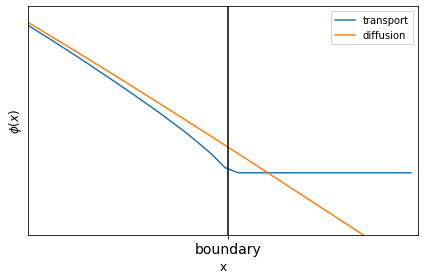

In [7]:
sp = openmc.StatePoint('statepoint.150.h5')

tallydf=sp.tallies[2].get_pandas_dataframe()

fitB=30 #in which region should we fit the cosine? [fitB:-fitB]
y=np.linspace(-rf,rf,Nmesh+1)
x=y+(y[1]-y[0])/2
x=x[:-1]

from scipy.optimize import curve_fit
p1,p2=curve_fit(lambda y,a,b: a*np.cos((np.pi/(2*(rc+b)))*y),  x[fitB:-fitB],  tallydf['mean'][fitB:-fitB]/(y[1]-y[0]))


plt.figure()

plt.plot(x,tallydf['mean']/(y[1]-y[0]),'-', label='transport')
plt.plot(x,(p1[0]*np.cos((np.pi/(2*(rc+p1[1])))*x)),label='diffusion')
plt.plot(x[fitB:-fitB],(p1[0]*np.cos((np.pi/(2*(rc+p1[1])))*x))[fitB:-fitB])
plt.axvline(0.0)
plt.axvline(rc,color='k')
plt.xlabel('x',fontsize=12)
plt.xticks([rc],['boundary'])
plt.yticks([],[])
plt.ylabel('$\phi(x)$',fontsize=12)
plt.legend()
plt.xlim(8.5,12)
plt.ylim(0,0.4)
plt.tight_layout()
#plt.savefig('04-vacuumboundaries.png',dpi=300)
plt.show()


## Analytic solutions of diffusion <a name="analyticdiffusion"></a>


Here we plot some analytic functions which come up as solutions to the diffusion equation in various geometries.

### cosine in multiplying slab

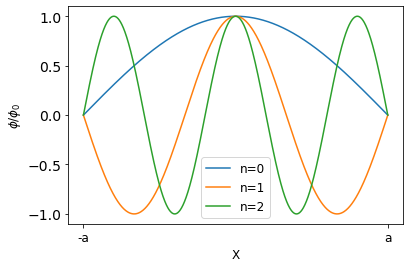

In [8]:
R=100
r=np.linspace(-R,R,1000)
plt.figure()
for n in [0,1,2]:
    B=(2*n+1)*np.pi/(2*R)
    plt.plot(r,np.cos(B*r),label='n=%d'%n)
plt.xlabel('X',fontsize=12)
plt.ylabel('$\phi/\phi_0$',fontsize=12)
plt.legend(fontsize=12)
plt.xticks([-R,R],['-a','a'],fontsize=12)
#plt.savefig('04-slabflux.png',dpi=300)
plt.show()

### exponential in non multiplying slab

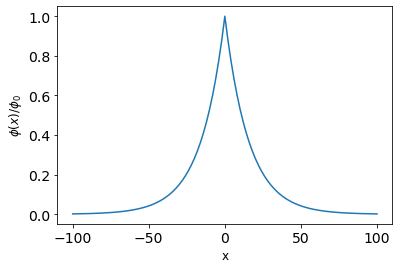

In [9]:
S0=1000
L=np.sqrt(250)
D=0.3
x=np.linspace(-100,100,201)
F=[]
F=(S0*L/2*D)*np.exp(-np.abs(x)/L)

        
plt.figure()
plt.plot(x,F/np.max(F))
plt.xlabel('x',fontsize=12)
plt.ylabel(r'$\phi(x)/\phi_0$',fontsize=12)
#plt.savefig('04-nonmultislab.png',dpi=300)
plt.show()

### Bessel and cosine in a 2D cylinder

Important to highlight, that a cylinder is infact a 3D object, we assume angular symmetry.

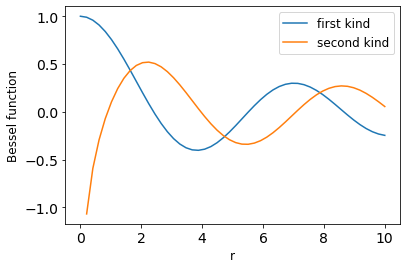

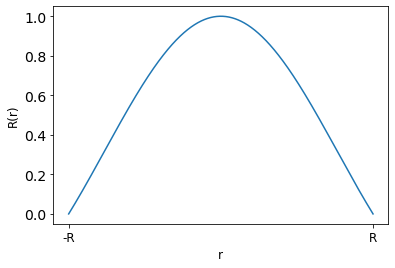

In [10]:
import scipy.special
x=np.linspace(0,10)
plt.figure()
plt.plot(x,scipy.special.jv(0,x),label='first kind')
plt.plot(x,scipy.special.yv(0,x),label='second kind')
plt.xlabel('r',fontsize=12)
plt.ylabel('Bessel function',fontsize=12)
plt.legend(fontsize=12)
#plt.savefig('04-besselfunction.png',dpi=300)
plt.show()

R=100
r=np.linspace(-R,R,1000)
plt.figure()
plt.plot(r,scipy.special.jv(0,2.405/R*r))
plt.xlabel('r',fontsize=12)
plt.ylabel('R(r)',fontsize=12)
plt.xticks([-R,R],['-R','R'],fontsize=12)
#plt.savefig('04-cylinderradialflux.png',dpi=300)
plt.show()

## Reflected geometries <a name="reflected"></a>


Spatial flux distribution in reflected geometries.

### Analytic solution from diffusion

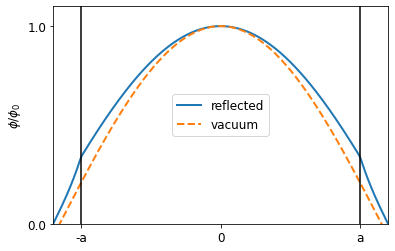

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def flux(x,Bc,Lr,a,b):
    #from D&H
    flux=[]
    for xi in x:
        if abs(xi)<=a/2:
            flux.append(np.cos(Bc*xi))
        else:
            flux.append(np.cos(Bc*a/2)*np.sinh((a/2+b-abs(xi))/Lr)/np.sinh(b/Lr))
    return flux
   
def incore(x,B):
    return np.cos(B*x)

   
nuSigma_fC=0.1570
Sigma_aC=0.1532
DC=3.85
DR=3.85

rc=25.0
rf=30.0 

a=rc*2
b=rf-rc
Sigma_aR=0.1*0.1532
LR=np.sqrt(DR/Sigma_aR)
BC=np.sqrt((nuSigma_fC-Sigma_aC)/DC)
LR=np.sqrt(DR/Sigma_aR)

x=np.linspace(-a/2,a/2,100)

BC=np.pi/(a+2*DC)*0.9
x=np.linspace(-a/2-b,a/2+b,200)

plt.figure()
Sigma_aR=0.1532
DR=3.85
LR=np.sqrt(DR/Sigma_aR)
plt.plot(x,flux(x,BC,LR,a,b),lw=2,label='reflected')
plt.plot(x,incore(x,np.pi/(a+2*DC)),'--',lw=2,label='vacuum')

plt.xlim(-a/2-b,a/2+b)
plt.ylim(0.0,1.1)
plt.axvline(rc, color='black')
plt.axvline(-rc,color='black')
plt.xticks([-rc,0.0,rc],['-a','0','a'],fontsize=12)
plt.yticks([0.0,1.0],[0.0,1.0],fontsize=12)
plt.ylabel(r'$\phi/\phi_0$',fontsize=12)
plt.legend(loc='center',fontsize=12)
#plt.savefig('04-reflectedslab_Diffusion.png',dpi=300)
plt.show()


### Analytic solution for reflector savings

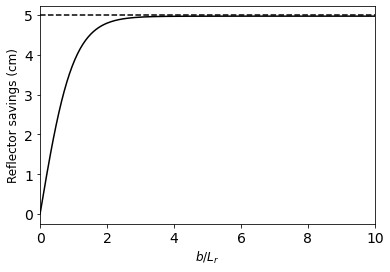

In [12]:
b=np.linspace(0,200,1000)
BC=np.sqrt((nuSigma_fC-Sigma_aC)/DC)

delta=1/BC*np.arctan(DC*BC*LR/DR*np.tanh(b/LR))

deltasat=DC/DR*LR

plt.figure()
plt.plot(b/LR,delta,'k')
plt.axhline(deltasat,linestyle='--',color='k')
plt.xlim(0,10)
plt.xlabel(r'$b/L_r$',fontsize=12)
plt.ylabel('Reflector savings (cm)',fontsize=12)
#plt.savefig('04-reflectorsavings.png',dpi=300)
plt.show()

### MC solution

We calculate the spatial flux distribution in a reflected homogeneous slab reactor with openMC. The flux is tallied in two energy groups.

In [13]:
import openmc
import  numpy as np
import matplotlib.pyplot as plt

fuelm = openmc.Material(1,"uo2")
fuelm.set_density('g/cm3', 10.0)
fuelm.add_nuclide('U235', 0.00153)
fuelm.add_nuclide('U238', 0.13847)
fuelm.add_nuclide('O16', 0.29)
fuelm.add_nuclide('H1', 0.57)
fuelm.add_s_alpha_beta('c_H_in_H2O')

water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

water.add_s_alpha_beta('c_H_in_H2O')

mats = openmc.Materials([fuelm,water])
mats.export_to_xml()

rc=25.0 #core
rf=30.0 #reflector 
Nmesh=201
core_1 = openmc.XPlane(x0=-rc)
core_2 = openmc.XPlane(x0=rc)

reflector_1 = openmc.XPlane(x0=-rf,boundary_type='vacuum')
reflector_2 = openmc.XPlane(x0=rf,boundary_type='vacuum')

fuel_region = +core_1 & -core_2
reflector1_region = +reflector_1 & -core_1
reflector2_region = +core_2 & -reflector_2

fuel = openmc.Cell(1, 'fuel')
fuel.fill = fuelm
fuel.region = fuel_region

reflector1 = openmc.Cell(2, 'reflector1')
reflector1.fill = water
reflector1.region = reflector1_region

reflector2 = openmc.Cell(3, 'reflector2')
reflector2.fill = water
reflector2.region = reflector2_region

root = openmc.Universe(cells=(fuel, reflector1, reflector2))

geom = openmc.Geometry()
geom.root_universe = root
geom.export_to_xml()

point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 250
settings.inactive = 20
settings.particles = 50000
settings.export_to_xml()

# Tally #1: energy spectrum in fuel

energy_filter2g = openmc.EnergyFilter([0.0, 0.625, 20.0e7])
energy_filter1g = openmc.EnergyFilter([0.0, 20.0e7])

#tally #2: 1Dmesh tally in whole geometry 
myMesh=openmc.Mesh(name='xmesh')
myMesh.dimension=[Nmesh]
myMesh.lower_left=[-rf]
myMesh.upper_right=[rf]
mesh_filter = openmc.MeshFilter(myMesh)

tm1 = openmc.Tally(1)
tm1.filters = [mesh_filter,energy_filter1g]
tm1.scores = ['flux']

tm2 = openmc.Tally(2)
tm2.filters = [mesh_filter,energy_filter2g]
tm2.scores = ['flux']

#all the tallies
tallies = openmc.Tallies([tm1,tm2])
tallies.export_to_xml()

import os
os.system('rm summary.h5')
os.system('rm statepoint.250.h5')
os.environ['OPENMC_CROSS_SECTIONS']='/home/zsolt/xs_openmc/cross_sections.xml'
openmc.run()

/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mesh.py:453: UserWarning: Mesh has been renamed RegularMesh. Future versions of

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      135/1    0.99936    1.00792 +/- 0.00056
      136/1    1.00237    1.00787 +/- 0.00055
      137/1    1.00506    1.00785 +/- 0.00055
      138/1    1.00472    1.00782 +/- 0.00054
      139/1    1.00833    1.00783 +/- 0.00054
      140/1    1.00920    1.00784 +/- 0.00054
      141/1    1.00869    1.00785 +/- 0.00053
      142/1    1.01111    1.00787 +/- 0.00053
      143/1    1.00771    1.00787 +/- 0.00052
      144/1    1.01007    1.00789 +/- 0.00052
      145/1    1.00576    1.00787 +/- 0.00052
      146/1    1.01368    1.00792 +/- 0.00051
      147/1    1.00477    1.00789 +/- 0.00051
      148/1    1.01044    1.00791 +/- 0.00051
      149/1    1.00024    1.00785 +/- 0.00051
      150/1    1.01611    1.00792 +/- 0.00051
      151/1    0.99806    1.00784 +/- 0.00051
      152/1    1.00259    1.00780 +/- 0.00051
      153/1    1.00295    1.00777 +/- 0.00050
      154/1    1.01012    1.00778 +/- 0.00050
      155/1    1.00437    1.00776 +/- 0.00050
      156/1    1.00539    1.00774 

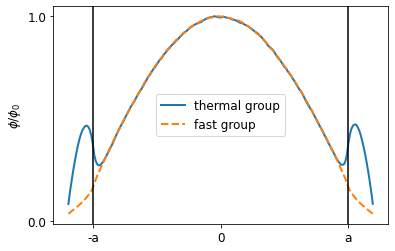

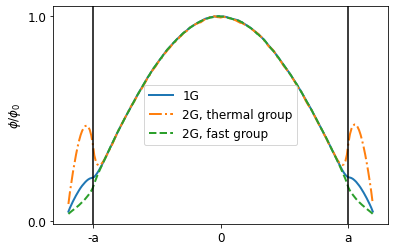

In [14]:
sp = openmc.StatePoint('statepoint.250.h5')

tallydf1=sp.tallies[1].get_pandas_dataframe()
tallydf2=sp.tallies[2].get_pandas_dataframe()
tallydf2.head()

y=np.linspace(-rf,rf,Nmesh+1)
x=y+(y[1]-y[0])/2
x=x[:-1]

plt.figure()
plt.plot(x,tallydf2[tallydf2['energy low [eV]']==0.0]['mean']/tallydf2[tallydf2['energy low [eV]']==0.0]['mean'].max(),label='thermal group',lw=2)
plt.plot(x,tallydf2[tallydf2['energy low [eV]']!=0.0]['mean']/tallydf2[tallydf2['energy low [eV]']!=0.0]['mean'].max(),'--',label='fast group',lw=2)
plt.legend(loc='center',fontsize=12)
plt.axvline(rc, color='black')
plt.axvline(-rc,color='black')
plt.xticks([-rc,0.0,rc],['-a','0','a'],fontsize=12)
plt.yticks([0.0,1.0],[0.0,1.0],fontsize=12)
plt.ylabel(r'$\phi/\phi_0$',fontsize=12)
#plt.savefig('04-reflectedslab_MC.png',dpi=300)
plt.show()

plt.figure()
plt.plot(x,tallydf1['mean']/tallydf1['mean'].max(),label='1G',lw=2)
plt.plot(x,tallydf2[tallydf2['energy low [eV]']==0.0]['mean']/tallydf2[tallydf2['energy low [eV]']==0.0]['mean'].max(),'-.',label='2G, thermal group',lw=2)
plt.plot(x,tallydf2[tallydf2['energy low [eV]']!=0.0]['mean']/tallydf2[tallydf2['energy low [eV]']!=0.0]['mean'].max(),'--',label='2G, fast group',lw=2)
plt.legend(loc='center',fontsize=12)
plt.axvline(rc, color='black')
plt.axvline(-rc,color='black')
plt.xticks([-rc,0.0,rc],['-a','0','a'],fontsize=12)
plt.yticks([0.0,1.0],[0.0,1.0],fontsize=12)
plt.ylabel(r'$\phi/\phi_0$',fontsize=12)
#plt.savefig('04-reflectedslab_MC.png',dpi=300)
plt.show()

## Control rod effects <a name="controlrod"></a>


Here we investigate how the axial flux distribution changes due to a control rod. For this we will consider a cylindrical homogeneous reactor with openMC.

In [15]:
import openmc
import  numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs

def rodworth(rodpos=0.01):

    fuelm = openmc.Material(1,"uo2")
    fuelm.set_density('g/cm3', 10.0)
    fuelm.add_nuclide('U235', 0.00229)
    fuelm.add_nuclide('U238', 0.13847)
    fuelm.add_nuclide('O16', 0.29)
    fuelm.add_nuclide('H1', 0.57)
    fuelm.add_s_alpha_beta('c_H_in_H2O')



    absorber = openmc.Material(3, "absorber")
    absorber.add_element('B', 1.0) 
    absorber.set_density('g/cm3', 3.0)

    mats = openmc.Materials([fuelm,absorber])

    rc=25.0
    Nmesh=201
    core = openmc.ZCylinder(r=rc,boundary_type='vacuum')
    core_1 = openmc.ZPlane(z0=-rc,boundary_type='vacuum')
    core_2 = openmc.ZPlane(z0=rc,boundary_type='vacuum')

    rod = openmc.ZCylinder(r=5.0)
    rod_z = openmc.ZPlane(z0=rc-rodpos)


    fuel_region1 = -core & +core_1 & -core_2 & +rod
    fuel_region2 = -rod & +core_1 & -rod_z

    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = fuelm
    fuel.region = fuel_region1 | fuel_region2

    rod_region = -rod & +rod_z & -core_2

    controlrod = openmc.Cell(2,'controlrod')
    controlrod.region = rod_region
    controlrod.fill = absorber

    root = openmc.Universe(cells=(fuel,controlrod))

    geom = openmc.Geometry()
    geom.root_universe = root

    point = openmc.stats.Point((0, 0, 0))
    src = openmc.Source(space=point)

    settings = openmc.Settings()
    settings.source = src
    settings.batches = 100
    settings.inactive = 10
    settings.particles = 50000

    # Tally #1: energy spectrum in fuel

    energy_filter2g = openmc.EnergyFilter([0.0, 0.625, 20.0e7])
    energy_filter1g = openmc.EnergyFilter([0.0, 20.0e7])

    #tally #2: 1Dmesh tally in whole geometry 
    myMesh=openmc.Mesh(name='zmesh')
    myMesh.dimension=[1,1,Nmesh]
    myMesh.lower_left=[-rc,-rc,-rc]
    myMesh.upper_right=[rc,rc,rc]
    mesh_filter = openmc.MeshFilter(myMesh)

    tm1 = openmc.Tally(1)
    tm1.filters = [mesh_filter]
    tm1.scores = ['flux']

    tm2 = openmc.Tally(2)
    tm2.filters = [mesh_filter,energy_filter2g]
    tm2.scores = ['flux']

    #all the tallies
    tallies = openmc.Tallies([tm1,tm2])
    
    model = openmc.model.Model(geom, mats, settings,tallies)
    return model

crpos=[0.0001, 15.0,30.0,45.0]
flux=[]
os.system('rm summary.h5')
for crp in crpos:
    mod=rodworth(rodpos=crp)
    plt.show()
    output=mod.run()
    sp = openmc.StatePoint(output)
    tallydf=sp.tallies[1].get_pandas_dataframe()
    flux.append(tallydf['mean'])
    os.system('rm %s'%output)
    os.system('rm summary.h5')


/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mesh.py:453: UserWarning: Mesh has been renamed RegularMesh. Future versions of OpenMC will not accept the name Mesh.
  warnings.warn("Mesh has been renamed RegularMesh. Future versions of "
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mesh.py:453: UserWarning: Mesh has been renamed RegularMesh. Future versions of OpenMC will not accept the name Mesh.
  warnings.warn("Mesh has been renamed RegularMesh. Future versions of "
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site

 Reading U238 from /home/zsolt/xs_openmc/U238.h5
 Reading O16 from /home/zsolt/xs_openmc/O16.h5
 Reading H1 from /home/zsolt/xs_openmc/H1.h5
 Reading B10 from /home/zsolt/xs_openmc/B10.h5
 Reading B11 from /home/zsolt/xs_openmc/B11.h5
 Reading c_H_in_H2O from /home/zsolt/xs_openmc/c_H_in_H2O.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.15581
        2/1    1.13570
        3/1    1.12473
        4/1    1.11238
        5/1    1.11595
        6/1    1.09790
        7/1    1.09425
        8/1    1.08564
        9/1    1.07017
       10/1    1.06336
       11/1    1.056

/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mesh.py:453: UserWarning: Mesh has been renamed RegularMesh. Future versions of OpenMC will not accept the name Mesh.
  warnings.warn("Mesh has been renamed RegularMesh. Future versions of "
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site

 Reading U238 from /home/zsolt/xs_openmc/U238.h5
 Reading O16 from /home/zsolt/xs_openmc/O16.h5
 Reading H1 from /home/zsolt/xs_openmc/H1.h5
 Reading B10 from /home/zsolt/xs_openmc/B10.h5
 Reading B11 from /home/zsolt/xs_openmc/B11.h5
 Reading c_H_in_H2O from /home/zsolt/xs_openmc/c_H_in_H2O.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.66155
        2/1    1.02443
        3/1    1.05594
        4/1    1.05340
        5/1    1.04884
        6/1    1.04591
        7/1    1.03342
        8/1    1.03333
        9/1    1.03415
       10/1    1.02830
       11/1    1.008

/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mesh.py:453: UserWarning: Mesh has been renamed RegularMesh. Future versions of OpenMC will not accept the name Mesh.
  warnings.warn("Mesh has been renamed RegularMesh. Future versions of "
/home/zsolt/anaconda3/envs/openmc-env/lib/python3.9/site

 Reading U238 from /home/zsolt/xs_openmc/U238.h5
 Reading O16 from /home/zsolt/xs_openmc/O16.h5
 Reading H1 from /home/zsolt/xs_openmc/H1.h5
 Reading B10 from /home/zsolt/xs_openmc/B10.h5
 Reading B11 from /home/zsolt/xs_openmc/B11.h5
 Reading c_H_in_H2O from /home/zsolt/xs_openmc/c_H_in_H2O.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.61472
        2/1    1.00330
        3/1    1.02256
        4/1    1.03762
        5/1    1.03556
        6/1    1.02219
        7/1    1.02352
        8/1    1.00926
        9/1    0.99659
       10/1    1.00002
       11/1    1.005

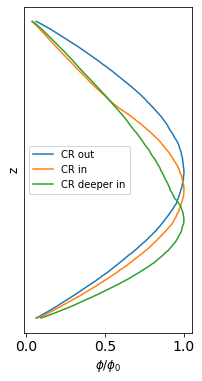

In [16]:
z=np.linspace(-25,25,201)
crpos=[0.0001, 15.0,30.0,45.0]
crposl=['CR out','CR in','CR deeper in','totally']
plt.figure(figsize=(3,6))
for f,c,cl in zip(flux,crpos,crposl):
    if c<35:
        plt.plot(f/np.max(f),z,label=cl)
plt.yticks([])
plt.xlabel(r'$\phi/\phi_0$',fontsize=12)
plt.ylabel('z',fontsize=12)
plt.legend()
#plt.savefig('04-controlrod.png',dpi=300)
plt.show()    

# Time dependence  <a name="time"></a>


Here come the figures related to point kinetics, subcritical systems and depletion.

## Point kinetics <a name="kinetics"></a>


### Point kinetics with and without delayed neutrons

Notice that related to this some exercises can be found in Datalab 8.

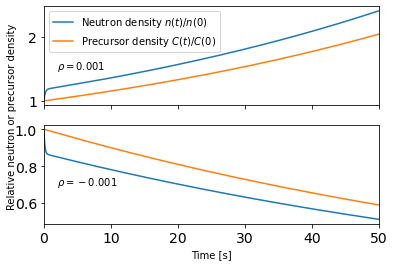

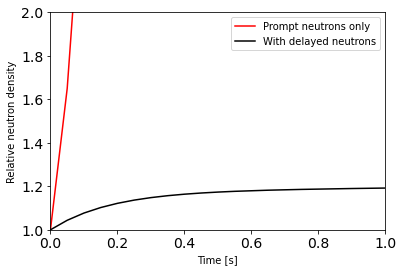

In [17]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    n, C = w
    rho, beta, Lambda, beta1, lambda1 = p

    # Create f = (n', C'):
    f = [((rho-beta)/Lambda)*n + lambda1*C,
         (beta1/Lambda)*n - lambda1*C]
    return f

def prompt_only(w, t, p):
    n = w[0]
    rho, l = p


    k = 1./(1. - rho)

    f = [((k - 1.)/l)*n]
    return f

# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint

rho = 0.001
beta = 0.0065
Lambda = 1e-3
beta_one_group = 0.0065
lambda_one_group = 0.08

## for 6 group:
beta1 = 0.000215
beta2 = 0.001424
beta3 = 0.001274
beta4 = 0.002568
beta5 = 0.000748
beta6 = 0.000273
lambda1 = np.log(2.)/55.72
lambda2 = np.log(2.)/22.72
lambda3 = np.log(2.)/6.22
lambda4 = np.log(2.)/2.30
lambda5 = np.log(2.)/0.610
lambda6 = np.log(2.)/0.230
# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
y1 = 1
y2 = (beta/(lambda_one_group*Lambda))*y1

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 50.0
numpoints = 250

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
#t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
t = np.linspace(0, stoptime, 1000)

# Pack up the parameters and initial conditions:
p = [rho, beta, Lambda, beta_one_group, lambda_one_group]
w0 = [y1, y2]

# Call the ODE solver.
wsol_pos = odeint(vectorfield, w0, t, args=(p,), atol=abserr, rtol=relerr)

# Call the ODE solver.
p = [-rho, beta, Lambda, beta_one_group, lambda_one_group]
wsol_neg = odeint(vectorfield, w0, t, args=(p,), atol=abserr, rtol=relerr)

l = 1e-4
p = [rho, l]
wsol_prompt_pos = odeint(prompt_only, 1, t, args=(p,), atol=abserr, rtol=relerr)


fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(t, wsol_pos[:, 0]/y1, label='Neutron density $n(t)/n(0)$')          ## n
ax[0].plot(t, wsol_pos[:, 1]/y2, label='Precursor density $C(t)/C(0)$')          ## C

ax[1].plot(t, wsol_neg[:, 0]/y1, label='Neutron density $n(t)/n(0)$')          ## n
ax[1].plot(t, wsol_neg[:, 1]/y2, label='Precursor density $C(t)/C(0)$')          ## C

ax[1].set_xlabel('Time [s]')
fig.text(0.04, 0.5, 'Relative neutron or precursor density', va='center', rotation='vertical')


ax[0].text(2, 1.5, r'$\rho = 0.001$', ha='left')
ax[1].text(2, 0.7, r'$\rho = -0.001$', ha='left')
plt.xlim(0, stoptime)
ax[0].legend()
plt.show()



plt.figure()
plt.plot(t, wsol_prompt_pos[:, 0]/y1, label='Prompt neutrons only', color='red')          ## n
plt.plot(t, wsol_pos[:, 0]/y1, label='With delayed neutrons', color='black')          ## n
plt.ylim(1, 2)
plt.xlim(0, 1)
plt.xlabel('Time [s]')
plt.ylabel('Relative neutron density')
plt.legend()
plt.show()


### Inhour equation in one group

      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 0.014520525178580324


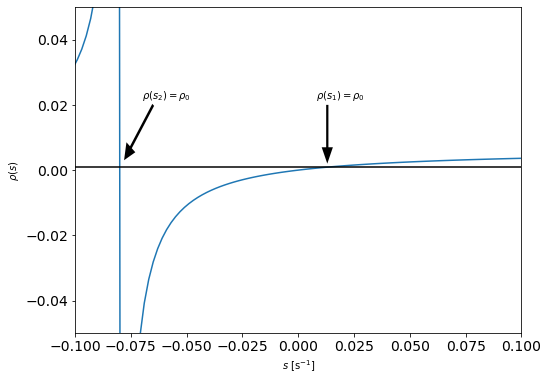

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Tasks:
## - Compare one-group and six-group inhour equations
## - numerically find the roots of the equation.
## - discuss differences/meaning
## - calculate the roots for i) rho_0 = 0, ii) positive rho_0, negative rho_0
## - perhaps also plot the power/flux change corresponding to each root (see how the different components die away)


def get_rho_one_group(s, l, beta, lambda_val):
    return (s*l)/(s*l + 1.) + (1./(s*l + 1.))*(s*beta/(s+lambda_val))

def get_inhour_roots(s, l, beta, lambda_val, rho_0):
    rho = get_rho_one_group(s, l, beta, lambda_val)

    return (rho - rho_0)

s = np.linspace(-100, 100, 100000)

l = 1e-4                ## Prompt neutron lifetime. 1e-4 for thermal reactor, 1e-7 for fast reactor (see D&H page 236)
## One group
beta = 0.0065
lambda_val = 0.08
rho_0 = 0.001

rho_one_group = get_rho_one_group(s, l, beta, lambda_val)

sol = optimize.root_scalar(get_inhour_roots, args=(l, beta, lambda_val, rho_0), bracket=[0, 3000], method='brentq')
print(sol)

plt.figure(figsize=(8,6))
plt.plot(s, rho_one_group)
plt.plot([-10000, 10000], [rho_0, rho_0], color='black', linestyle='-')
plt.xlim(-1e-1, 1e-1)
plt.ylim(-0.05, 0.05)
plt.xlabel('$s$ [s$^{-1}$]')
plt.ylabel(r'$\rho(s)$')

plt.arrow(0.013, 0.02, 0., -0.013, head_width=0.005, head_length=0.005, fc='k', ec='k', linewidth=0.01)
plt.text(0.008, 0.022, r'$\rho(s_1) = \rho_0$')
plt.arrow(-0.065, 0.02, -0.01, -0.013, head_width=0.005, head_length=0.005, fc='k', ec='k', linewidth=0.01)
plt.text(-0.07, 0.022, r'$\rho(s_2) = \rho_0$')
#plt.savefig('inhour_one_group.png')
plt.show()


### Inhour equation with six groups

<ipython-input-19-190eae084483>:8: RuntimeWarning: divide by zero encountered in true_divide
  sum_terms += s*beta[i]/(s + lambda_val[i])
<ipython-input-19-190eae084483>:10: RuntimeWarning: divide by zero encountered in true_divide
  return (s*l)/(s*l + 1.) + (1./(s*l + 1.))*sum_terms
<ipython-input-19-190eae084483>:10: RuntimeWarning: invalid value encountered in add
  return (s*l)/(s*l + 1.) + (1./(s*l + 1.))*sum_terms
<ipython-input-19-190eae084483>:79: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('symlog', linthreshx=0.1)


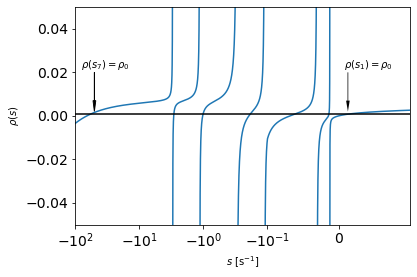

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def get_rho_six_group(s, l, beta, lambda_val):
    sum_terms = 0.
    for i in range(6):
        sum_terms += s*beta[i]/(s + lambda_val[i])

    return (s*l)/(s*l + 1.) + (1./(s*l + 1.))*sum_terms


def transform_s_six_group(s, x_scale):
    for i in range(len(s)):
        print(s[i])
    

def get_inhour_roots(s, l, beta, lambda_val, rho_0):
    rho = get_rho_six_group(s, l, beta, lambda_val)

    return (rho - rho_0)


s = np.linspace(-10000, 10000, 10000000)

l = 1e-4                ## Prompt neutron lifetime. 1e-4 for thermal reactor, 1e-7 for fast reactor (see D&H page 236)

## Six group
beta = np.array([0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273])
lambda_val = np.array([0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01])

rho_0 = 0.001


s_six_group = np.zeros(0)

for i in range(0, 9):
    if (i == 0):
        left_side = -100000.
        right_side = -1./l
    elif (i == 1):
        left_side = -1./l
        right_side = -lambda_val[5]
    elif (i == 2):
        left_side = -lambda_val[5]
        right_side = -lambda_val[4]
    elif (i == 3):
        left_side = -lambda_val[4]
        right_side = -lambda_val[3]
    elif (i == 4):
        left_side = -lambda_val[3]
        right_side = -lambda_val[2]
    elif (i == 5):
        left_side = -lambda_val[2]
        right_side = -lambda_val[1]
    elif (i == 6):
        left_side = -lambda_val[1]
        right_side = -lambda_val[0]
    elif (i == 7):
        left_side = -lambda_val[0]
        right_side = 10.
    elif (i == 8):
        left_side = 10.
        right_side = 10000.

    s = np.linspace(left_side, right_side, 1000000)
    s_six_group = np.append(s_six_group, s)


rho_six_group = get_rho_six_group(s_six_group, l, beta, lambda_val)



plt.figure()
plt.plot(s_six_group, rho_six_group)
plt.plot([-10000, 10000], [rho_0, rho_0], color='black', linestyle='-')
plt.ylim(-0.05, 0.05)
plt.xlim(-100, 0.1)
plt.xscale('symlog', linthreshx=0.1)
plt.xlabel('$s$ [s$^{-1}$]')
plt.ylabel(r'$\rho(s)$')

plt.arrow(0.013, 0.02, 0., -0.013, head_width=0.005, head_length=0.005, fc='k', ec='k', linewidth=0.01)
plt.text(0.008, 0.022, r'$\rho(s_1) = \rho_0$')
plt.arrow(-50, 0.02, 0., -0.013, head_width=5, head_length=0.005, fc='k', ec='k', linewidth=0.9)
plt.text(-80, 0.022, r'$\rho(s_7) = \rho_0$')
#plt.savefig('inhour_six_group.png')
plt.show()

### Reactor period

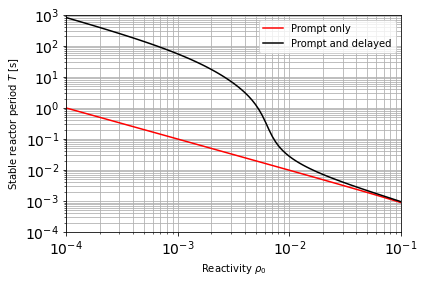

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## possible todo: ADD CODE TO COMPARE EXACT POINT KINETICS WITH APPROXIMATE POINT KINETICS (see http://kth.diva-portal.org/smash/get/diva2:500623/FULLTEXT01.pdf p61)

def get_rho_six_group(s, l, beta, lambda_val):
    sum_terms = 0.
    for i in range(6):
        sum_terms += s*beta[i]/(s + lambda_val[i])

    return (s*l)/(s*l + 1.) + (1./(s*l + 1.))*sum_terms


def transform_s_six_group(s, x_scale):
    for i in range(len(s)):
        print(s[i])
    

def get_inhour_roots(s, l, beta, lambda_val, rho_0):
    rho = get_rho_six_group(s, l, beta, lambda_val)

    return (rho - rho_0)


def T_prompt(l, rho_0):
    return l*(1 - rho_0)/rho_0


s = np.linspace(-10000, 10000, 10000000)

l = 1e-4                ## Prompt neutron lifetime. 1e-4 for thermal reactor, 1e-7 for fast reactor (see D&H page 236)

## Six group
beta = np.array([0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273])
lambda_val = np.array([0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01])

rho_0 = np.logspace(-4, -1, 100)
T = np.zeros(100)


for i in range(len(rho_0)):
    sol = optimize.root_scalar(get_inhour_roots, args=(l, beta, lambda_val, rho_0[i]), bracket=[0, 10000000], method='brentq')                 ## max at 10000000 works for fast reactor
    T[i] = 1./sol.root


plt.plot(rho_0, T_prompt(l, rho_0), color='red', label='Prompt only')
plt.plot(rho_0, T, color='black', label='Prompt and delayed')

plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Reactivity $\rho_0$')
plt.ylabel(r'Stable reactor period $T$ [s]')

plt.xlim(1e-4, 1e-1)
plt.ylim(1e-4, 1e3)
plt.grid(which='both')
#plt.savefig('reactor_period_thermal.png')
plt.show()

## Subcritical systems <a name="subcritical"></a>


### Neutron multiplication in subcritical systems

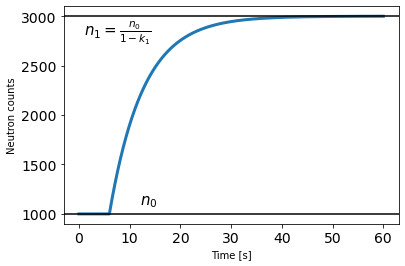

In [21]:
import matplotlib.pyplot as plt
import numpy as np

t = [0]*60*60
s0 = 1000
k1 = 0.5
l = 200
time = [0]*60*60

for i in range(0,360):
    t[i] = s0
    time[i] = i/60

for i in range(360,3600,1):
    t[i] = s0 + s0/(1-k1)*(1-np.exp(-(1-k1)/l*(i-360)))
    time[i] = i/60
    
plt.figure()
plt.plot(time,t, linewidth=3)
plt.xlabel("Time [s]")
plt.ylabel("Neutron counts")

plt.axhline(1000, color='black')
plt.axhline(3000, color='black')
plt.text(12, 1100, "$n_0$", fontsize=15)
plt.text(1, 2800, r"$n_1 = \frac{n_0}{1-k_1}$", fontsize=15)
#plt.savefig('1overM.png',dpi=300) 
plt.show()

### 1/M plot

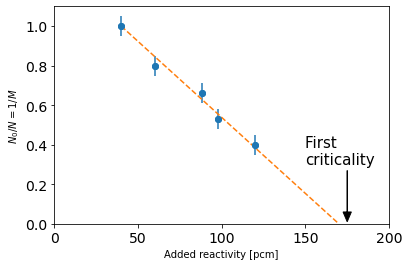

In [22]:
M = [1.0, 0.80, 0.66, 0.53, 0.40]
reactivity = [40,60,88,98,120]

syntheticError = [0.05]*5
    
plt.figure()
plt.scatter(reactivity, M)
plt.errorbar(reactivity, M, yerr=syntheticError, fmt="o")
plt.xlim([0,200])
plt.ylim([0,1.1])
plt.plot([40,170],[1,0], '--')
plt.xlabel("Added reactivity [pcm]")
plt.ylabel("$N_0/N = 1/M$")
plt.text(150, 0.3, "First \ncriticality", fontsize=15)
plt.arrow(175, 0.27, 0, -0.21, head_width=5, head_length=0.05, fc='k', ec='k', linewidth=0.9)
#plt.savefig('1overM_plot.png',dpi=300) 
plt.show()

### Sjöstrand method

Count values taken from the reactor physics exercises of Z. Szatmary.

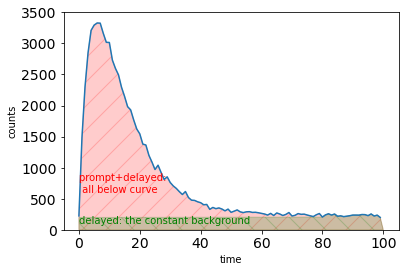

In [23]:
import matplotlib.pyplot as plt

counts=[223,1482,2298,2849,3210,3295,3329,3326,3163,3018,3015,2731,2598,2494,2294,2147,1982,1930,1768,1623,1544,1379,1365,1198,1090,970,1040,922,810,852,761,706,666,614,568,616,519,477,473,451,436,403,408,329,360,340,352,334,305,333,281,300,320,289,277,289,292,280,282,274,264,254,237,264,230,271,254,230,248,278,222,233,261,249,252,238,225,213,242,262,205,240,258,237,254,218,225,212,219,227,237,237,236,246,244,228,255,222,236,199]

promptPolycorners=[[x,y] for x,y in enumerate(counts)] #all function x,y pairs will be a corner for polygon
#pythonic way of
#polycorners = []
#for x,y in enumerate(counts):
#    polycorners.append([x,y])
promptPolycorners.append([len(counts),0])
promptPolycorners.append([0,0])

delayedPolycorners=promptPolycorners[-22:] #22 instead of 20, because the two appended corners are also there!
delayedPolycorners.append([0,counts[-1]])

plt.figure()
plt.plot(counts)    
polygonP = plt.Polygon(promptPolycorners, True,color='red',alpha=0.2,hatch='/')
polygonD = plt.Polygon(delayedPolycorners, True,color='green',alpha=0.2,hatch='\\')
plt.gca().add_line(polygonP)
plt.text(0,600,'prompt+delayed: \n all below curve',color='r')
plt.gca().add_line(polygonD)
plt.text(0,100,'delayed: the constant background',color='green')
plt.xlabel('time')
plt.ylabel('counts')
plt.ylim(0,3500)
plt.show()

### Rossi-alpha

first an illustration of the method:

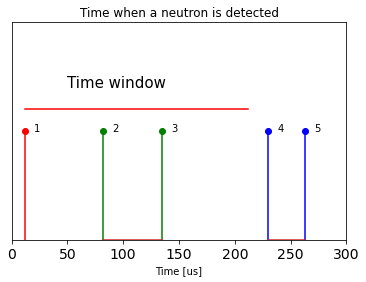

In [24]:
d = [12,82,135,230,263]

#plot the first 20 events
plt.figure()
plt.stem([12],[1], 'r', markerfmt='ro', use_line_collection =True)
plt.stem(d[1:3],[1]*2, 'g', markerfmt='go', use_line_collection =True)
plt.stem(d[3:],[1]*2, 'b', markerfmt='bo', use_line_collection =True)
plt.xlabel("Time [us]")
plt.gca().axes.get_yaxis().set_visible(False)  
plt.xlim([0,300])
plt.ylim([0,2])
plt.plot([12,212],[1.2,1.2], 'r')
plt.text(50, 1.4, "Time window", fontsize=15)
plt.text(20,1,"1", fontsize=10)
plt.text(90,1,"2", fontsize=10)
plt.text(143,1,"3", fontsize=10)
plt.text(238,1,"4", fontsize=10)
plt.text(271,1,"5", fontsize=10)
plt.title("Time when a neutron is detected")
#plt.savefig('Neutron_timing.png',dpi=300) 
plt.show()

then an illustration of the Rossi-alpha distribution (this is an idealization to have smooth curves, however Datalab 9 contains a simulation which can be used to create more realistic "experimental" distributions)

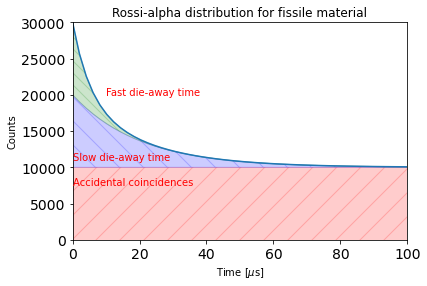

In [25]:
import numpy as np
import matplotlib.pyplot as plt
Accidentals = np.ones(50)*10000
evaluation_points = np.linspace(0,100,50)
fast = 10000*np.exp(-1*evaluation_points/5)
slow = 10000*np.exp(-1*evaluation_points/20)

total = Accidentals + fast + slow

accidentals_polycorners = [[0,0],[0,10000],[100,10000],[100,0]]
slow_polycorners = [[100,10000],[0,10000]]
for x in range(0,50):
    slow_polycorners.append([evaluation_points[x],slow[x]+Accidentals[x]])
    
fast_polycorners = []
for x in range(0,50):
    fast_polycorners.append([evaluation_points[x],slow[x]+Accidentals[x]])
for x in range(1,51):
    fast_polycorners.append([evaluation_points[-x],slow[-x]+Accidentals[-x] +fast[-x]])
       
plt.figure()
plt.plot(evaluation_points, total)

polygonC = plt.Polygon(accidentals_polycorners, True,color='red',alpha=0.2,hatch='/')
plt.gca().add_line(polygonC)
plt.text(0,7500,'Accidental coincidences',color='r')

polygonS = plt.Polygon(slow_polycorners, True,color='blue',alpha=0.2,hatch='\\')
plt.gca().add_line(polygonS)
plt.text(0,11000,'Slow die-away time',color='r')

polygonF = plt.Polygon(fast_polycorners, True,color='green',alpha=0.2,hatch='\\\\')
plt.gca().add_line(polygonF)
plt.text(10,20000,'Fast die-away time',color='r')

plt.xlim([0,100])
plt.ylim([0,30000])
plt.xlabel("Time [$\mu$s]")
plt.ylabel("Counts")
plt.title("Rossi-alpha distribution for fissile material")
#plt.savefig('Rossi_alpha_slow_fast.png',dpi=300) 
plt.show()

## Depletion <a name="depletion"></a>


### Depletion chain: U238

this is somewhat similar code as used for the radioactive decay chain. Again it is based on the depletion chain xml-s from openMC, however now some other reactions are also included.

In [26]:
symToZ= {'Mt': 109, 'Hs': 108, 'Bh': 107, 'Sg': 106, 'Db': 105, 'Rf': 104, 'Lr': 103, 'No': 102, 'Md': 101, 'Fm': 100, 'Es': 99, 'Cf': 98, 'Bk': 97, 'Cm': 96, 'Am': 95, 'Pu': 94, 'Np': 93, 'U': 92, 'Pa': 91, 'Th': 90, 'Ac': 89, 'Ra': 88, 'Fr': 87, 'Rn': 86, 'At': 85, 'Po': 84, 'Bi': 83, 'Pb': 82, 'Tl': 81, 'Hg': 80, 'Au': 79, 'Pt': 78, 'Ir': 77, 'Os': 76, 'Re': 75, 'W': 74, 'Ta': 73, 'Hf': 72, 'Lu': 71, 'Yb': 70, 'Tm': 69, 'Er': 68, 'Ho': 67, 'Dy': 66, 'Tb': 65, 'Gd': 64, 'Eu': 63, 'Sm': 62, 'Pm': 61, 'Nd': 60, 'Pr': 59, 'Ce': 58, 'La': 57, 'Ba': 56, 'Cs': 55, 'Xe': 54, 'I': 53, 'Te': 52, 'Sb': 51, 'Sn': 50, 'In': 49, 'Cd': 48, 'Ag': 47, 'Pd': 46, 'Rh': 45, 'Ru': 44, 'Tc': 43, 'Mo': 42, 'Nb': 41, 'Zr': 40, 'Y': 39, 'Sr': 38, 'Rb': 37, 'Kr': 36, 'Br': 35, 'Se': 34, 'As': 33, 'Ge': 32, 'Ga': 31, 'Zn': 30, 'Cu': 29, 'Ni': 28, 'Co': 27, 'Fe': 26, 'Mn': 25, 'Cr': 24, 'V': 23, 'Ti': 22, 'Sc': 21, 'Ca': 20, 'K': 19, 'Ar': 18, 'Cl': 17, 'S': 16, 'P': 15, 'Si': 14, 'Al': 13, 'Mg': 12, 'Na': 11, 'Ne': 10, 'F': 9, 'O': 8, 'N': 7, 'C': 6, 'B': 5, 'Be': 4, 'Li': 3, 'He': 2, 'H': 1}
import xml.etree.ElementTree as ET
tree = ET.parse('chain_endfb71_pwr.xml')
root = tree.getroot()

nuclides={}
for child in root:
    nuclides[child.attrib['name']]=child.attrib
    if 'decay_modes' in child.attrib:
        nuclides[child.attrib['name']]['decay']=[grandchild.attrib for grandchild in child if grandchild.tag=='decay']
    if 'reactions' in child.attrib:
        nuclides[child.attrib['name']]['reaction']=[grandchild.attrib for grandchild in child if grandchild.tag=='reaction']
        

decay_modes={}
reaction_modes={}
half_lifes={}
import re
def addNuclide(nucl):
    sym,A,_=re.split(r'(\d+)', nucl.split('_')[0]) #will fail if an isomer is present
    Z=symToZ[sym] #if it doesn't find symToZ within the function, looks outside. Be careful with such.
    
    if Z>=92 and int(A)<=244:

        if 'half_life' in nuclides[nucl]:
            half_lifes[nucl]=float(nuclides[nucl]['half_life'])
            #I will only consider alpha and beta- decay. It could be extended to others, also notice eg. Tl210 has 'beta-,n'
            decay_modes[nucl]=[dec['type'] for dec in nuclides[nucl]['decay'] if ('alpha'==dec['type'] or 'beta-'==dec['type'])]
            targets=[dec['target'] for dec in nuclides[nucl]['decay'] if ('alpha'==dec['type'] or 'beta-'==dec['type'])]
            for target in targets:
                addNuclide(target)
        else:
            decay_modes[nucl]=['stable']

        if 'reactions' in nuclides[nucl]:
            #half_lifes[nucl]=float(nuclides[nucl]['half_life'])
            #I will only consider alpha and beta- decay. It could be extended to others, also notice eg. Tl210 has 'beta-,n'
            reaction_modes[nucl]=[rec['type'] for rec in nuclides[nucl]['reaction'] if ('(n,gamma)'==rec['type'] or '(n,2n)'==rec['type'])]
            targets=[rec['target'] for rec in nuclides[nucl]['reaction'] if ('(n,gamma)'==rec['type'] or '(n,2n)'==rec['type'])]
            for target in targets:
                sym,A,_=re.split(r'(\d+)', target.split('_')[0]) #will fail if an isomer is present
                Z=symToZ[sym] #if it doesn't find symToZ within the function, looks outside. Be careful with such.

                if (target not in reaction_modes) and Z>=92 and Z<=96 and int(A)>=235 and int(A)<=244:
                    addNuclide(target)

startNuc='U238'
startA=int(re.split(r'(\d+)', startNuc.split('_')[0])[1])
addNuclide(startNuc)

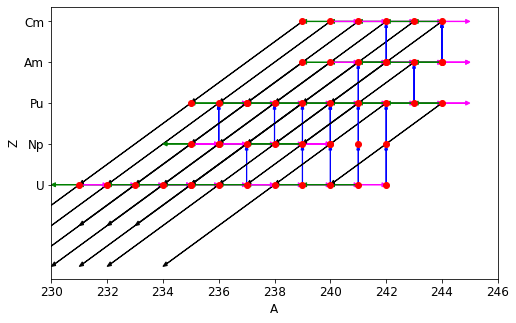

In [27]:
import matplotlib as mpl


label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

def createDotArrow(nuc):
    import re
    sym,A,_=re.split(r'(\d+)', nuc.split('_')[0]) #will fail if an isomer is present
    Z=symToZ[sym] #if it doesn't find symToZ within the function, looks outside. Be careful with such.
    A=int(A)
    if 'stable' in decay_modes[nuc]:
        plt.plot(A,Z,'bo')
    else:
        plt.plot(A,Z,'ro')
    for dm in decay_modes[nuc]:
        if dm=='alpha':
            plt.arrow(A,Z,-4,-2,width=0.01,length_includes_head=True,head_width=0.1,color='black')
        if dm=='beta-':
            plt.arrow(A,Z,0,1,width=0.01,length_includes_head=True,head_width=0.1,color='blue')
    for rec in reaction_modes[nuc]:
        if rec=='(n,gamma)':
            plt.arrow(A,Z,1,0,width=0.01,length_includes_head=True,head_width=0.1,color='magenta')
        if rec=='(n,2n)':
            plt.arrow(A,Z,-1,0,width=0.01,length_includes_head=True,head_width=0.1,color='green')
plt.figure(figsize=(8,5))
for nuc in reaction_modes:
    createDotArrow(nuc)
#we take only the Element symbols which are present to define the yticks
currentSymToZ={re.split(r'(\d+)', key.split('_')[0])[0]: symToZ[re.split(r'(\d+)', key.split('_')[0])[0]] for key in decay_modes}
plt.yticks(list(currentSymToZ.values()),list(currentSymToZ.keys()))
plt.xlabel('A',fontsize=12)
plt.ylabel('Z',fontsize=12)
plt.xlim(230,246)
#plt.savefig('04-chaincomplete.png',dpi=300)
plt.show()

### Idealized chain around U-235 and U-238

instead of using the xml file, we manually preselect reactions to be plotted.

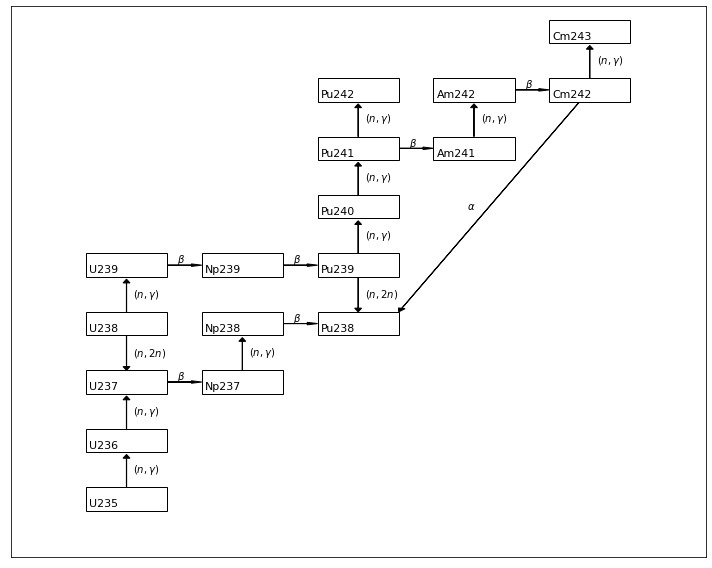

In [28]:
import matplotlib.pyplot as plt

toplot={'U235':['(n,gamma)'],
        'U236':['(n,gamma)'],
        'U237':['beta-'],
        'U238':['(n,gamma)','(n,2n)'],
        'U239':['beta-'],
        'Np237':['(n,gamma)'],
        'Np238':['beta-'],
        'Np239':['beta-'],
        'Pu238':[],
        'Pu239':['(n,gamma)','(n,2n)'],
        'Pu240':['(n,gamma)'],
        'Pu241':['(n,gamma)','beta-'],
        'Pu242':[],
        'Am241':['(n,gamma)'],
        'Am242':['beta-'],
        'Cm242':['alpha','(n,gamma)'],
        'Cm243':[]}

xsize=3.5/2
ysize=2.8/2
xloc=5
yloc=7
fig, ax = plt.subplots(figsize=(10,8))
for key in toplot:
    sym,A,_=re.split(r'(\d+)', key.split('_')[0]) 
    Z=symToZ[sym]
    A=int(A)
    x=(Z-91)*xloc
    y=(A-234)*yloc
    for rec in toplot[key]:
        if rec=='alpha':
            xn=(Z-2-91)*xloc
            yn=(A-4-234)*yloc
            plt.arrow(x,y,xn-x+xsize,yn-y+ysize,width=0.01,length_includes_head=True,head_width=0.3,color='black')
            plt.annotate(r'$\alpha$',((x+xn)/2-0.3,(y+yn)/2-0.3))
        if rec=='beta-':
            xn=(Z+1-91)*xloc
            yn=(A-234)*yloc
            plt.arrow(x+xsize,y,xn-x-2.0*xsize,yn-y,width=0.01,length_includes_head=True,head_width=0.3,color='black')
            plt.annotate(r'$\beta$',((x+xn)/2-0.3,(y+yn)/2+0.3))
        if rec=='(n,gamma)':
            xn=(Z-91)*xloc
            yn=(A+1-234)*yloc
            plt.arrow(x,y+ysize,xn-x,yn-y-2.2*ysize,width=0.01,length_includes_head=True,head_width=0.3,color='black')
            plt.annotate(r'$(n,\gamma)$',((x+xn)/2+0.3,(y+yn)/2-0.3))
        if rec=='(n,2n)':
            xn=(Z-91)*xloc
            yn=(A-1-234)*yloc
            plt.arrow(x,y-ysize,xn-x,yn-y+2.*ysize,width=0.01,length_includes_head=True,head_width=0.3,color='black')
            plt.annotate(r'$(n,2n)$',((x+xn)/2+0.3,(y+yn)/2-0.3))
            
            
    polygon=plt.Polygon([[x-xsize,y+ysize],[x+xsize,y+ysize],
                         [x+xsize,y-ysize],[x-xsize,y-ysize]],facecolor='white',edgecolor='black')
    ax.add_artist(polygon)
    plt.annotate(key,(x-xsize+0.15,y-ysize+0.5),fontsize=11)

plt.xlim(0,30)
plt.ylim(0,66)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
#plt.savefig('04-uranchain.png',dpi=300)
plt.show()
    

### Typical dependence of activity/nuclide concentration on time

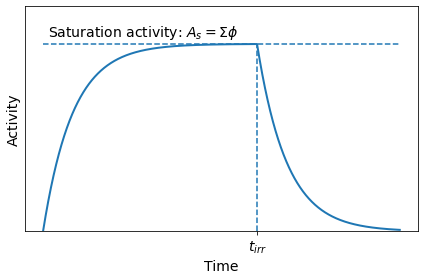

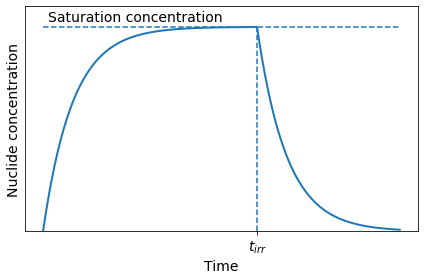

In [29]:
import numpy as np
import matplotlib.pyplot as plt
t=np.linspace(0,400,10000)

lam=0.03
A0=5

A=[]
N=[]
tirr=6000 #index of tirr
for ti in t[:tirr]:
    A.append(A0*(1-np.exp(-lam*ti)))
    N.append(A0/lam*(1-np.exp(-lam*ti)))
for ti in t[tirr:]:
    A.append(5*(1-np.exp(-lam*t[tirr-1]))*np.exp(-lam*(ti-t[tirr-1])))
    N.append(5/lam*(1-np.exp(-lam*t[tirr-1]))*np.exp(-lam*(ti-t[tirr-1])))

plt.figure()
plt.plot(t,A,lw=2)
plt.ylim(0,A0+1)
plt.hlines(A0,linestyle='--',xmin=0,xmax=400)
plt.vlines(x=t[tirr-1],linestyle='--', ymin=0,ymax=5)
plt.annotate(r'Saturation activity: $A_s=\Sigma\phi$',xy=(6, 5.2), xytext=(6, 5.2),fontsize=14)
plt.xticks([t[tirr-1]],[r'$t_{irr}$'],fontsize=14)
plt.yticks([])
plt.xlabel('Time',fontsize=14)
plt.ylabel('Activity',fontsize=14)
plt.tight_layout()
#plt.savefig('04-saturation_activity.png',dpi=300)
plt.show()

plt.figure()
plt.plot(t,N,lw=2)
plt.ylim(0,A0/lam*1.1)
plt.hlines(A0/lam,linestyle='--',xmin=0,xmax=400)
plt.vlines(x=t[tirr-1],linestyle='--', ymin=0,ymax=A0/lam)
plt.annotate(r'Saturation concentration',(6, A0/lam*1.03),fontsize=14)
plt.xticks([t[tirr-1]],[r'$t_{irr}$'],fontsize=14)
plt.yticks([])
plt.xlabel('Time',fontsize=14)
plt.ylabel('Nuclide concentration',fontsize=14)
plt.tight_layout()
#plt.savefig('04-saturation_concentration.png',dpi=300)
plt.show()

### Xenon concentration and poisoning

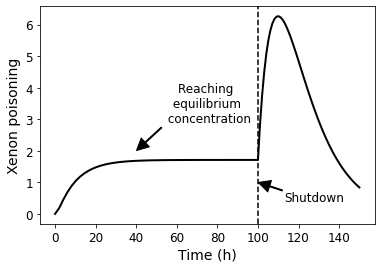

In [30]:
Y_Xe=7.507970e-04
Y_I=2.922920e-02+3.211290e-02 #for I-135 and Te135
Sigma_f=8.19863245263419E-04*583 #barn-1cm-1 * barn
phi=1e14
T_12_Xe=9.17*60*60 #s
T_12_I=6.58*60*60 #s
lambda_Xe=np.log(2)/T_12_Xe
lambda_I=np.log(2)/T_12_I
sigma_Xe=2e6*1e-24 #barn to cm2


Sig_a_U=0.0157 #from Ex5

#some helper variables
C_I=Y_I*Sigma_f*phi
C_Xe=Y_Xe*Sigma_f*phi
R_Xe=sigma_Xe*phi
c=C_I/(R_Xe-lambda_I+lambda_Xe)-(C_I+C_Xe)/(R_Xe+lambda_Xe)

t=np.linspace(0,50)*60*60
N_I=C_I/lambda_I - (C_I/lambda_I)*np.exp(-lambda_I*t)
N_Xe=c*np.exp(t*(-R_Xe-lambda_Xe)) + C_Xe/(R_Xe+lambda_Xe) - (C_I/(R_Xe-lambda_I+lambda_Xe))*np.exp(-lambda_I*t) + C_I/(R_Xe+lambda_Xe) 


N_I_inf=C_I/lambda_I
N_Xe_inf=(C_I+C_Xe)/(R_Xe+lambda_Xe)

N_Xe_shut = N_Xe_inf*np.exp(-lambda_Xe*t)+((lambda_I*N_I_inf)/(lambda_I-lambda_Xe))*(np.exp(-lambda_Xe*t)-np.exp(-lambda_I*t))

t=np.linspace(0,100)*60*60
import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
N_I=C_I/lambda_I - (C_I/lambda_I)*np.exp(-lambda_I*t)
N_Xe=c*np.exp(t*(-R_Xe-lambda_Xe)) + C_Xe/(R_Xe+lambda_Xe) - (C_I/(R_Xe-lambda_I+lambda_Xe))*np.exp(-lambda_I*t) + C_I/(R_Xe+lambda_Xe) 
t=np.linspace(0,50)*60*60
N_Xe_shut = N_Xe_inf*np.exp(-lambda_Xe*t)+((lambda_I*N_I_inf)/(lambda_I-lambda_Xe))*(np.exp(-lambda_Xe*t)-np.exp(-lambda_I*t))
tall=np.concatenate((np.linspace(0,100)*60*60,100*60*60+np.linspace(0,50)*60*60))
N_Xeall=np.concatenate((N_Xe,N_Xe_shut))
Sig_a_Xe=sigma_Xe*N_Xe_shut
plt.figure()
plt.annotate('Reaching \n equilibrium \n concentration', size=12, xy=(40, 2),  xycoords='data',
            xytext=(0.5, 0.65), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=1, shrink=0.01),
            horizontalalignment='center', verticalalignment='top',
            )
plt.annotate('Shutdown', size=12, xy=(100, 1),  xycoords='data',
            xytext=(0.91, 0.15), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=1, shrink=0.01),
            horizontalalignment='right', verticalalignment='top',
            )
plt.plot(tall/60/60,sigma_Xe*N_Xeall/Sig_a_U,'k',lw=2)
plt.axvline(100,ls='--',c='k')
plt.xlabel('Time (h)',fontsize=14)
plt.ylabel('Xenon poisoning',fontsize=14)
#plt.savefig('04-xenonpoisoning.png',dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.plot(t/60/60,N_Xe_shut)
plt.xlabel('Time (h)',fontsize=14)

plt.ylabel('Xenon concentration',fontsize=14)
plt.yticks([])
#plt.savefig('04-xenonconcentration.png',dpi=300)
plt.show()

# Appendix  <a name="appendix"></a>

## Colored Pi

A black and white image of Pi has been rendered with Inkscape, and the digits of Pi (pi.dat) has been downloaded. The script colors the image's pixels according the digits (not that the axis is not part of the image, hence when saving the image it is not saved). 

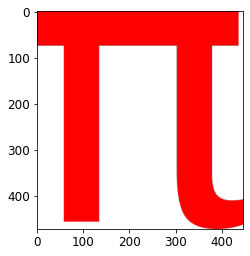

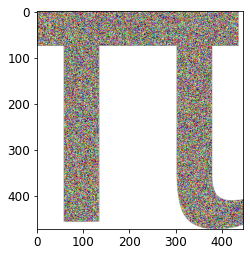

In [31]:
pidatastr=open('pi.dat','r').read()

import numpy as np

colors={key:[np.random.random(), np.random.random(), np.random.random()] for key in range(10)}

colors={}
colors[0]=[0,0,0]
colors[1]=[1,1,0]
colors[2]=[1,0,1]
colors[3]=[0,1,1]
colors[4]=[192/255,192/255,192/255]
colors[5]=[1,102/255,0]
colors[6]=[1,0,0]
colors[7]=[0,1,0]
colors[8]=[0,0,1]
colors[9]=[204/255,1,1]



import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
# Read Image 
img = mpimg.imread('random_pi_rect.png') 
plt.figure()
plt.imshow(img) 
plt.show()

k=0
for i,col in enumerate(img):
    for j,pix in enumerate(col):
        if pix[-1]!=0.0:
            col=colors[int(pidatastr[k])]
            img[i,j][0]=col[0]#[np.random.randint(255),np.random.randint(255),np.random.randint(255),0.0]
            img[i,j][1]=col[1]
            img[i,j][2]=col[2]
            k=k+1

plt.figure()
plt.imshow(img) 
#plt.imsave('randomized_pi_rect.png', img)
plt.show()